In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load libraries**


In [ ]:
import pandas_datareader as pdr
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import copy
from tqdm import tqdm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeRegressor
from collections import OrderedDict
import quandl

# **Section 1: Load Data**

In [ ]:
# Macro economic indicators (mostly US) from the FRED database
# Detailed info on each indicator check on web: https://fred.stlouisfed.org/series/<indicator_name>
# DOC with the metrics and external exploratory Colab: https://docs.google.com/document/d/1Cf4C3Xz4_yitlzPaLEknHoDlw7KMXey4c49kZ7ucQEE/edit?usp=sharing

FRED_INDICATORS = ['GDP', 'GDPC1', 'GDPPOT', 'NYGDPMKTPCDWLD',         # 1. Growth
                   'CPIAUCSL', 'CPILFESL', 'GDPDEF',                   # 2. Prices and Inflation
                   'M1SL', 'WM1NS', 'WM2NS', 'M1V', 'M2V', 'WALCL',    # 3. Money Supply
                   'DFF', 'DTB3', 'DGS5', 'DGS10', 'DGS30', 'T5YIE',   # 4. Interest Rates
                   'T10YIE', 'T5YIFR', 'TEDRATE', 'DPRIME',            # 4. Interest Rates
                   'UNRATE', 'NROU', 'CIVPART', 'EMRATIO',             # 5. Employment
                   'UNEMPLOY', 'PAYEMS', 'MANEMP', 'ICSA', 'IC4WSA',   # 5. Employment
                   'CDSP', 'MDSP', 'FODSP', 'DSPIC96', 'PCE', 'PCEDG', # 6. Income and Expenditure
                   'PSAVERT', 'DSPI', 'RSXFS',                         # 6. Income and Expenditure
                   'INDPRO', 'TCU', 'HOUST', 'GPDI', 'CP', 'STLFSI2',  # 7. Other indicators
                   'DCOILWTICO', 'DTWEXAFEGS', 'DTWEXBGS',             # 7. Other indicators
                   'GFDEBTN', 'GFDEGDQ188S',                           # 8. Gov-t debt
                   # 9. Additional indicators from IVAN
                   'DEXUSEU', 'GVZCLS', 'VIXCLS', 'DIVIDEND',
                   # 9. Additional indicators from IVAN
                   'MORTGAGE30US', 'SPCS20RSA'
                   ]

# Macro Indicators from QUANDL
QUANDL_INDICATORS = {'USTREASURY/YIELD', 'USTREASURY/REALYIELD',  # 9. Additional indicators from IVAN
                     # 9. Additional indicators from IVAN
                     'MULTPL/SHILLER_PE_RATIO_MONTH', 'LBMA/GOLD'
                     }

# Stock maret indexes
  # All indexes: https://stooq.com/t/ 
STOOQ_INDICATORS = {'^SPX'}  

# update period for each ind (Y=Yearly, Q=Quarterly, M=Monthly, W=Weekly, D=Daily)
INDICATORS_PERIODS = {'GDP': 'Q', 'GDPC1': 'Q', 'GDPPOT': 'Q', 'NYGDPMKTPCDWLD': 'Y',                 # 1. Growth
                      # 2. Prices and Inflation
                      'CPIAUCSL': 'M', 'CPILFESL': 'M', 'GDPDEF': 'Q',
                      # 3. Money Supply
                      'M1SL': 'M', 'WM1NS': 'W', 'WM2NS': 'W', 'M1V': 'Q', 'M2V': 'Q', 'WALCL': 'W',
                      # 4. Interest Rates
                      'DFF': 'D', 'DTB3': 'D', 'DGS5': 'D', 'DGS10': 'D', 'DGS30': 'D', 'T5YIE': 'D',
                      # 4. Interest Rates
                      'T10YIE': 'D', 'T5YIFR': 'D', 'TEDRATE': 'D', 'DPRIME': 'D',
                      # 5. Employment
                      'UNRATE': 'M', 'NROU': 'Q', 'CIVPART': 'M', 'EMRATIO': 'M',
                      # 5. Employment
                      'UNEMPLOY': 'M', 'PAYEMS': 'M', 'MANEMP': 'M', 'ICSA': 'W', 'IC4WSA': 'W',
                      # 6. Income and Expenditure
                      'CDSP': 'Q', 'MDSP': 'Q', 'FODSP': 'Q', 'DSPIC96': 'M', 'PCE': 'M', 'PCEDG': 'M',
                      # 6. Income and Expenditure
                      'PSAVERT': 'M', 'DSPI': 'M', 'RSXFS': 'M',
                      # 7. Other indicators
                      'INDPRO': 'M', 'TCU': 'M', 'HOUST': 'M', 'GPDI': 'Q', 'CP': 'Q', 'STLFSI2': 'W',
                      # 7. Other indicators
                      'DCOILWTICO': 'D', 'DTWEXAFEGS': 'D', 'DTWEXBGS': 'D',
                      # 8. Gov-t debt
                      'GFDEBTN': 'Q', 'GFDEGDQ188S': 'Q',
                      # 9. FRED: Additional indicators from IVAN
                      'DEXUSEU': 'D', 'GVZCLS': 'D', 'VIXCLS': 'D', 'DIVIDEND': 'Q',
                      # 9. FRED: Additional indicators from IVAN
                      'MORTGAGE30US': 'W', 'SPCS20RSA': 'M',
                      # 9.QUANDL: Additional indicators from IVAN
                      'USTREASURY_YIELD': 'D', 'USTREASURY_REALYIELD': 'D',
                      'MULTPL_SHILLER_PE_RATIO_MONTH': 'M', 'LBMA_GOLD': 'D',
                      # 10. INDEXES
                      'SPX': 'D', 
                      }

In [ ]:
end = date.today()
end=date(year=end.year-1, month=end.month+6, day=end.day+7)
start = date(year=end.year-35, month=end.month, day=end.day)
macro_indicators = dict()
tq_fred = tqdm(FRED_INDICATORS)

# get the stats from FRED database (with Pandas Datareader API)
tq_fred.set_description('Downloading stats from FRED:')
for indicator in tq_fred:
  # tq_fred.set_description(indicator)
  # macro_indicators[indicator] = pdr.DataReader(indicator, "fred", start=start, timeout=90)
  macro_indicators[indicator] = pdr.fred.FredReader(indicator, start=start, timeout=90).read()

for indicator in tqdm(STOOQ_INDICATORS):
    macro_indicators[indicator.replace("^", "")]= pdr.get_data_stooq(indicator, start, end)

tq_quandl = tqdm(QUANDL_INDICATORS)
# get the stats from QUANDL database
tq_quandl.set_description("Downloading stats from QUANDL:")
for indicator in tq_quandl:
 # tq_quandl.set_description(indicator)
 # modify all indicator names '/': like "USTREASURY/YIELD" to "USTREASURY_YIELD"
 macro_indicators[indicator.replace("/", "_")] = quandl.get(indicator, start_date=start, end_date=end, authtoken="5qE7KbLemDiZ9RfNsVuM")

100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


In [ ]:
for i,value in enumerate(macro_indicators.keys()):
    if i%6==0:
        print('\n')
    print(value, end =", ")



GDP, GDPC1, GDPPOT, NYGDPMKTPCDWLD, CPIAUCSL, CPILFESL, 

GDPDEF, M1SL, WM1NS, WM2NS, M1V, M2V, 

WALCL, DFF, DTB3, DGS5, DGS10, DGS30, 

T5YIE, T10YIE, T5YIFR, TEDRATE, DPRIME, UNRATE, 

NROU, CIVPART, EMRATIO, UNEMPLOY, PAYEMS, MANEMP, 

ICSA, IC4WSA, CDSP, MDSP, FODSP, DSPIC96, 

PCE, PCEDG, PSAVERT, DSPI, RSXFS, INDPRO, 

TCU, HOUST, GPDI, CP, STLFSI2, DCOILWTICO, 

DTWEXAFEGS, DTWEXBGS, GFDEBTN, GFDEGDQ188S, DEXUSEU, GVZCLS, 

VIXCLS, DIVIDEND, MORTGAGE30US, SPCS20RSA, SPX, USTREASURY_YIELD, 

USTREASURY_REALYIELD, LBMA_GOLD, MULTPL_SHILLER_PE_RATIO_MONTH, 

In [ ]:
# Total indicators 
len(macro_indicators.keys())

63

In [ ]:
# ORIGINAL STATS (need to reverse SPX ):

macro_indicators['SPX'].head()

Open     High      Low    Close      Volume
Date                                                      
2021-12-31  4775.21  4786.83  4765.75  4766.18  1339318824
2021-12-30  4794.23  4808.93  4775.33  4778.73  1353236996
2021-12-29  4788.64  4804.06  4778.08  4793.06  1365873126
2021-12-28  4795.49  4807.02  4780.04  4786.35  1432143549
2021-12-27  4733.99  4791.49  4733.99  4791.19  1503734418

In [ ]:
# to reverse SPX dataset:
macro_indicators['SPX'] = macro_indicators['SPX'].reindex(index=macro_indicators['SPX'].index[::-1])
macro_indicators['SPX'].tail()

Open     High      Low    Close      Volume
Date                                                      
2021-12-27  4733.99  4791.49  4733.99  4791.19  1503734418
2021-12-28  4795.49  4807.02  4780.04  4786.35  1432143549
2021-12-29  4788.64  4804.06  4778.08  4793.06  1365873126
2021-12-30  4794.23  4808.93  4775.33  4778.73  1353236996
2021-12-31  4775.21  4786.83  4765.75  4766.18  1339318824

# **Section 2: Data Exploration**

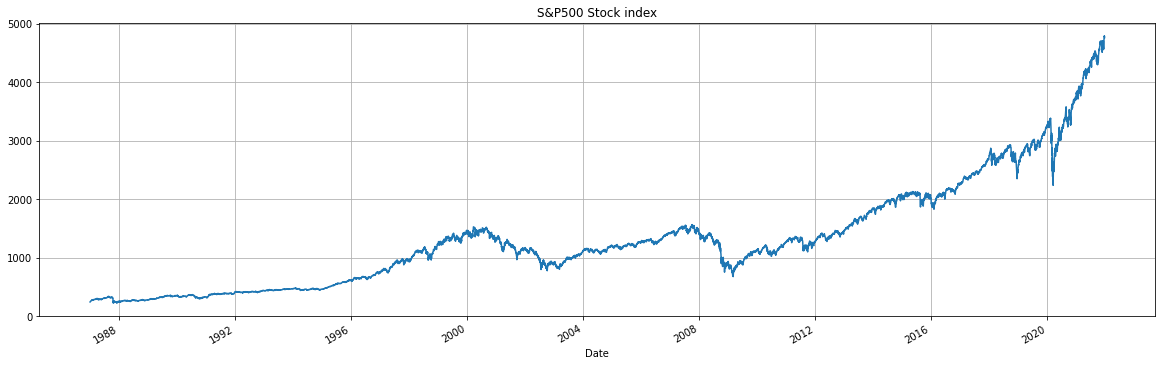

In [ ]:
macro_indicators['SPX']['Close'].plot.line(figsize=(20,6), grid = True, title='S&P500 Stock index')

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

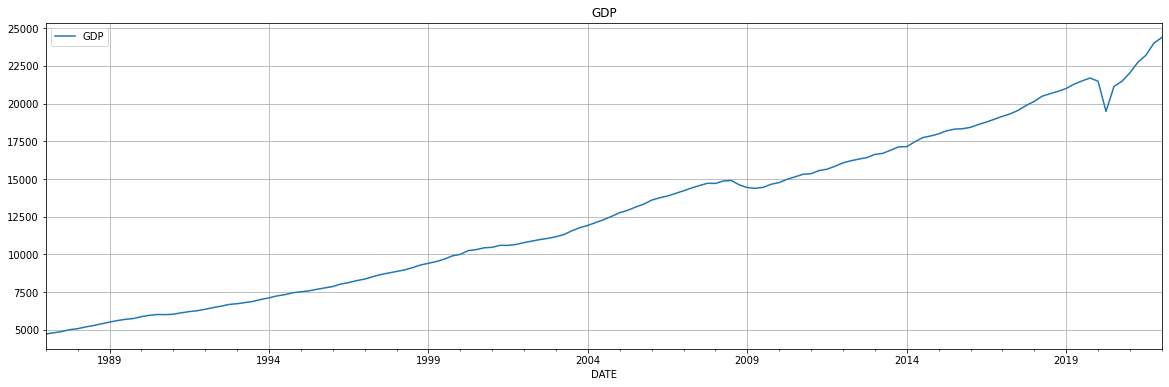

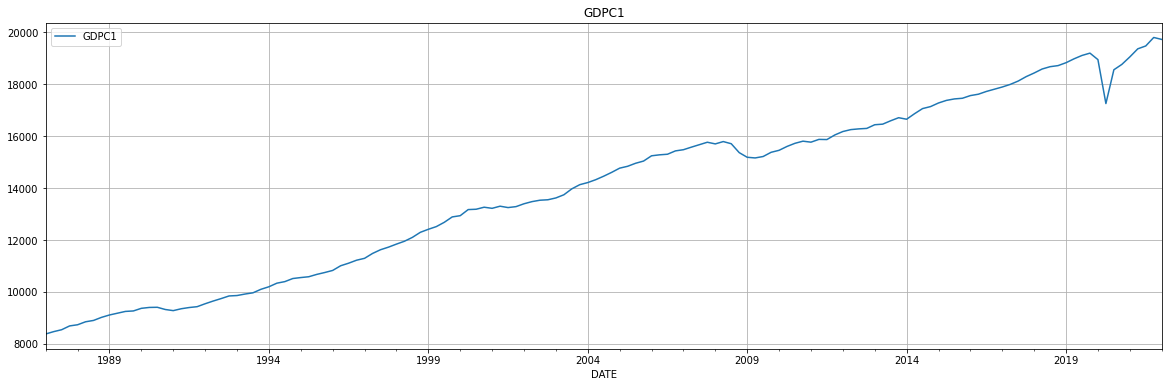

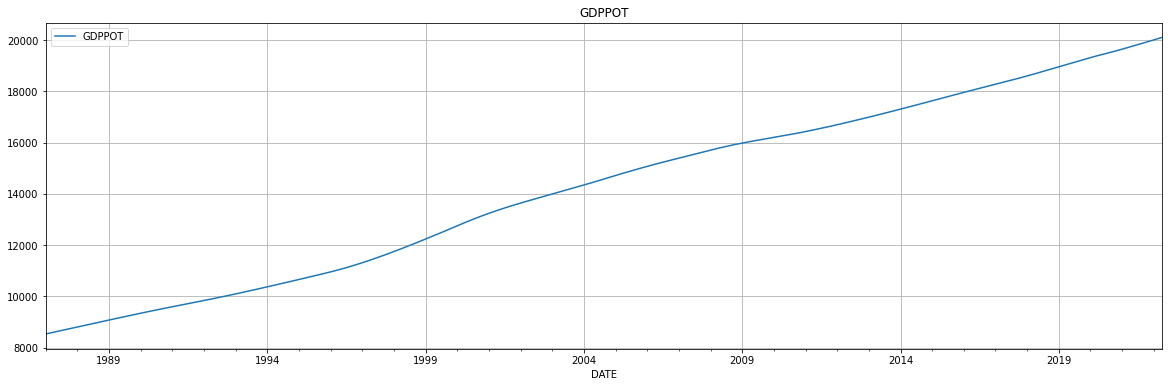

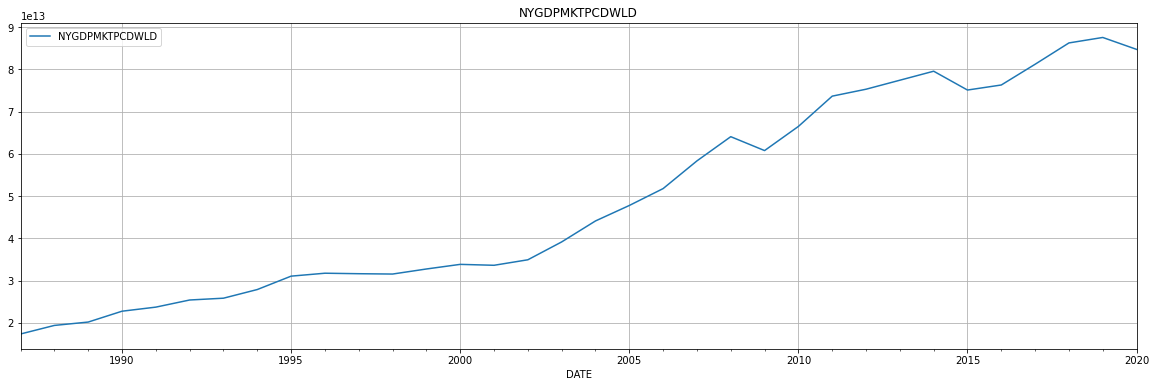

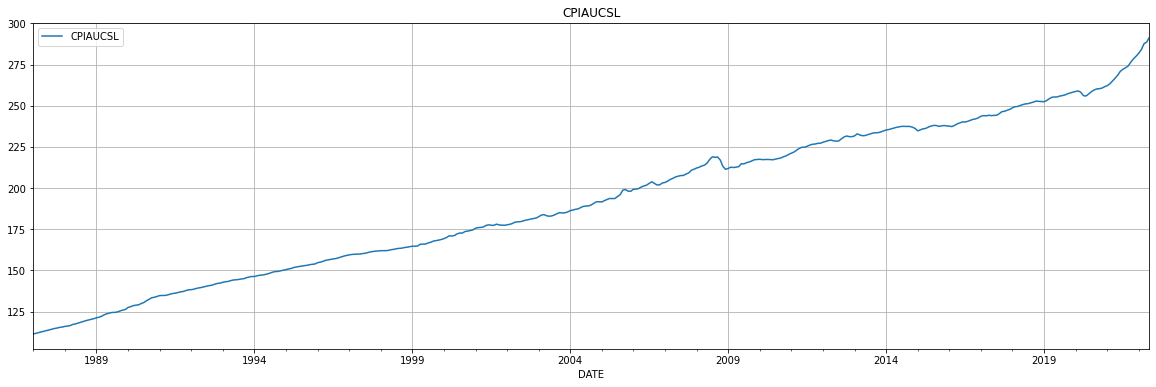

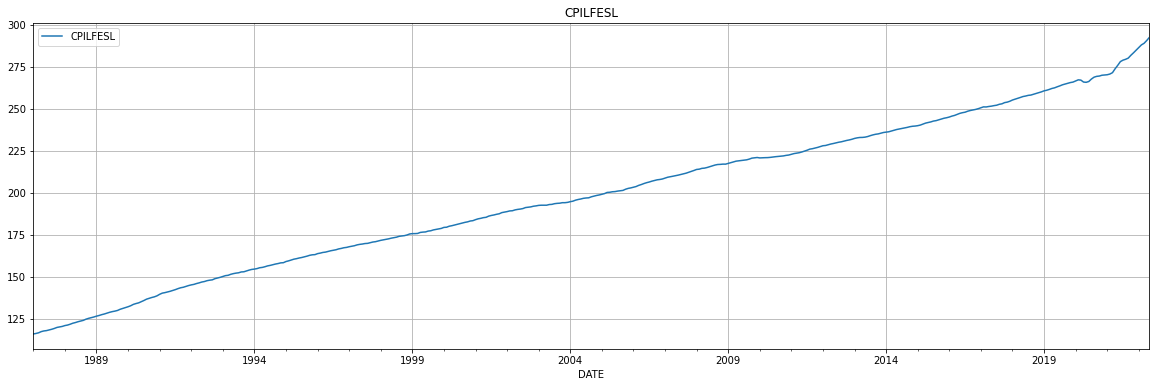

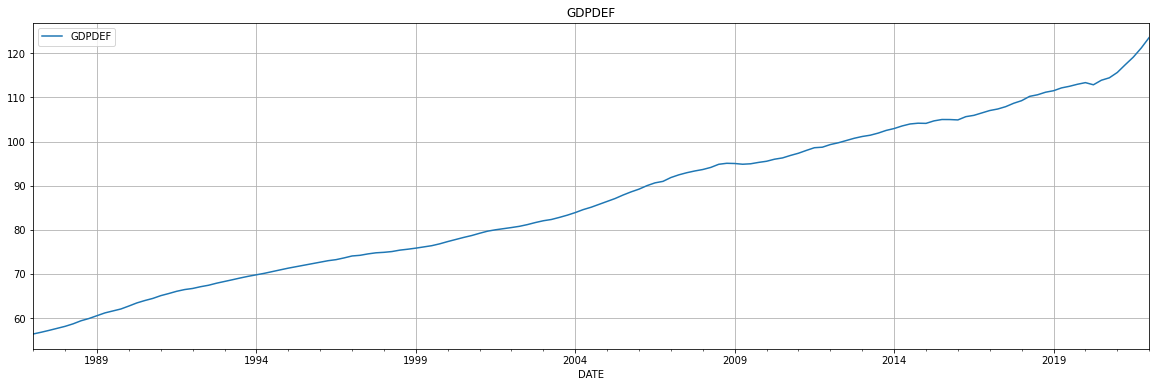

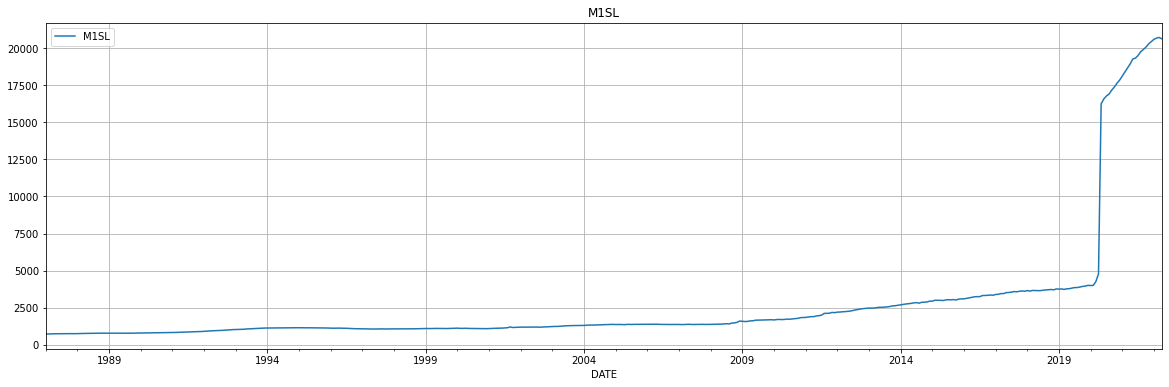

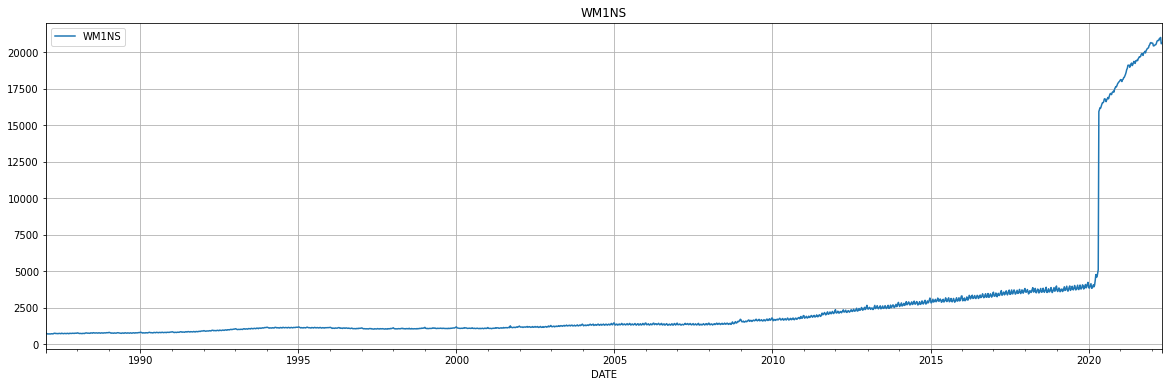

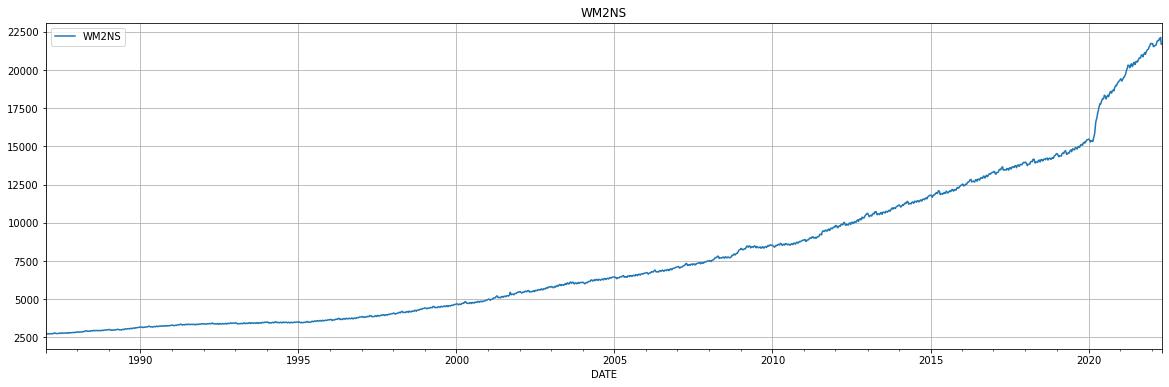

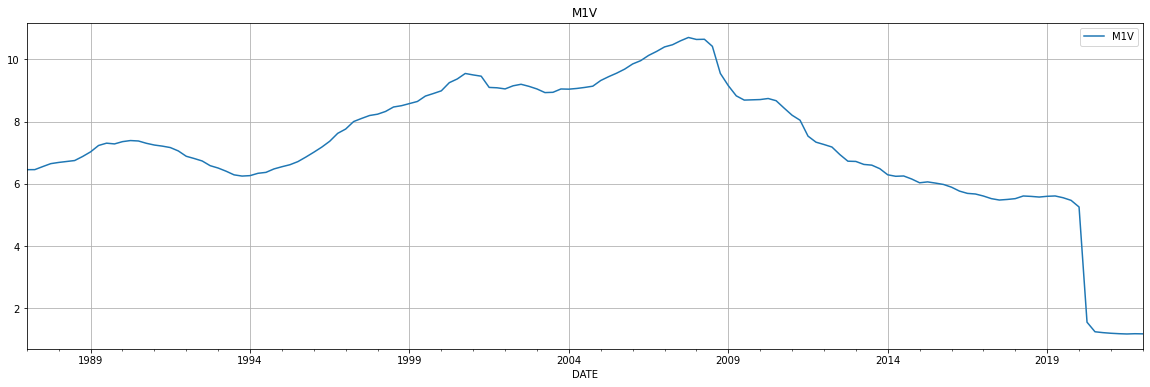

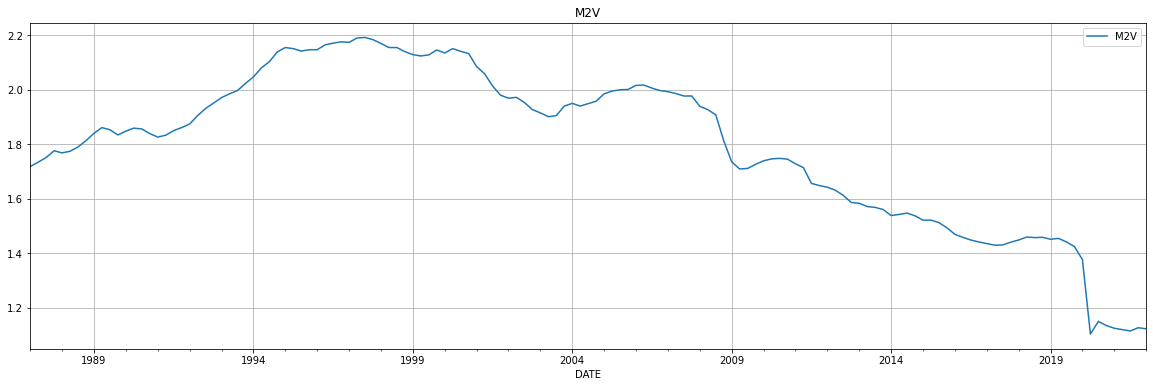

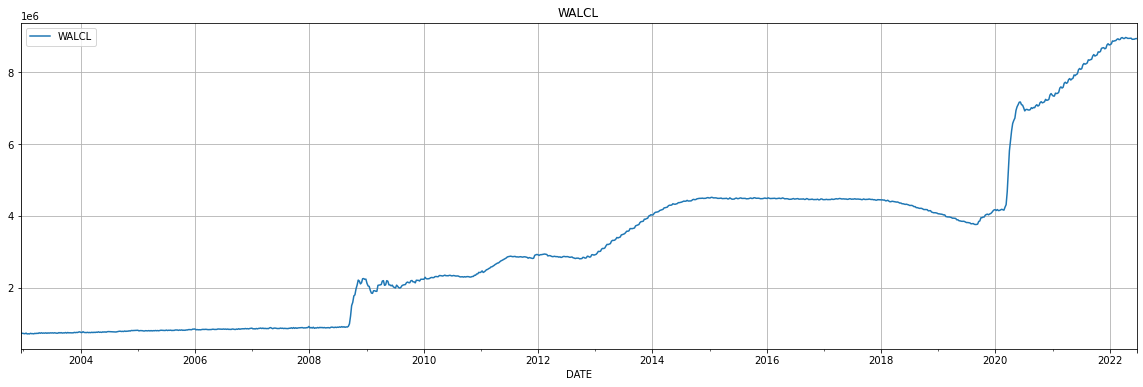

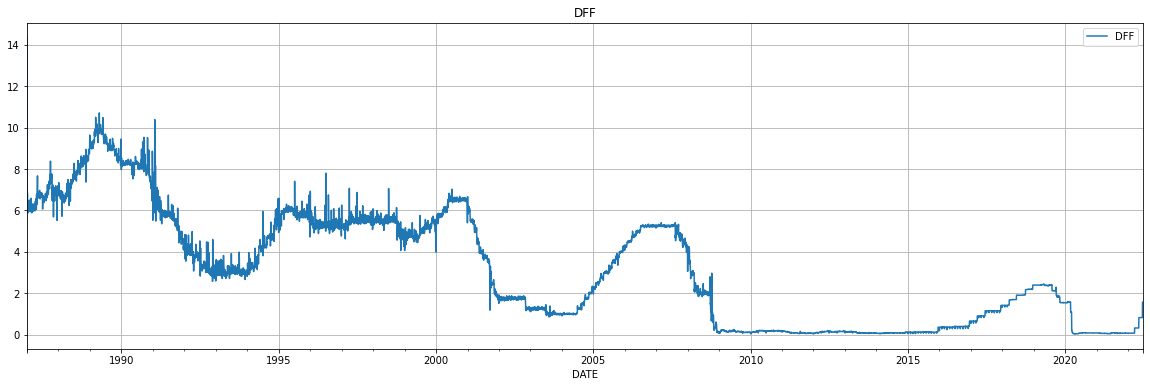

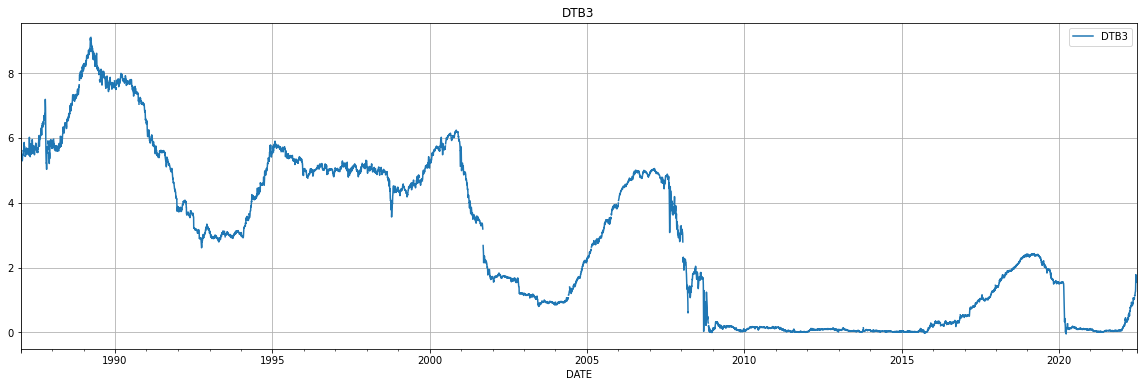

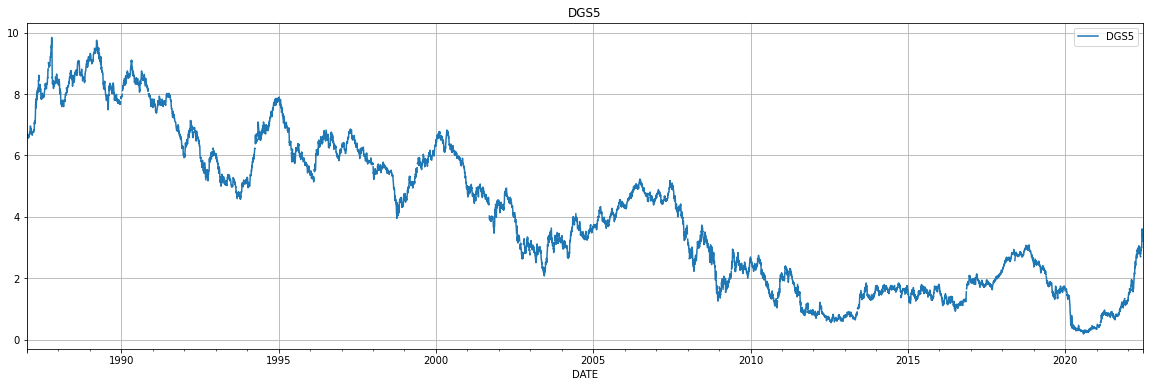

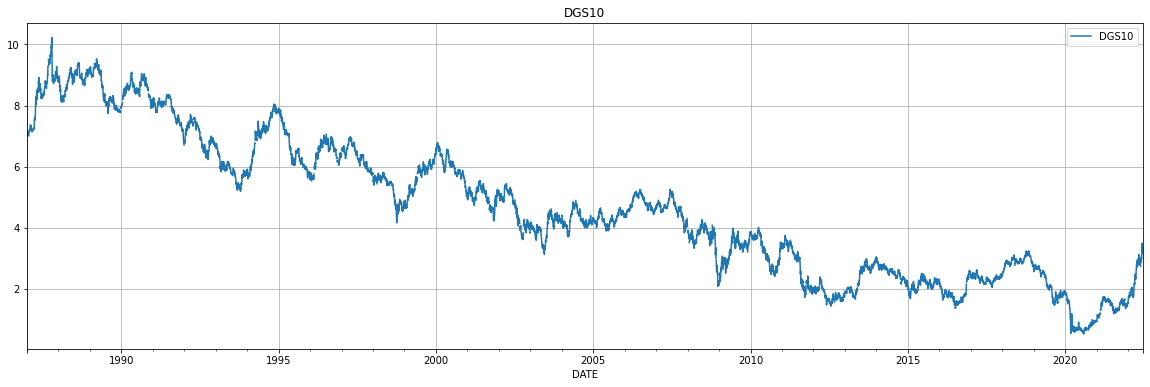

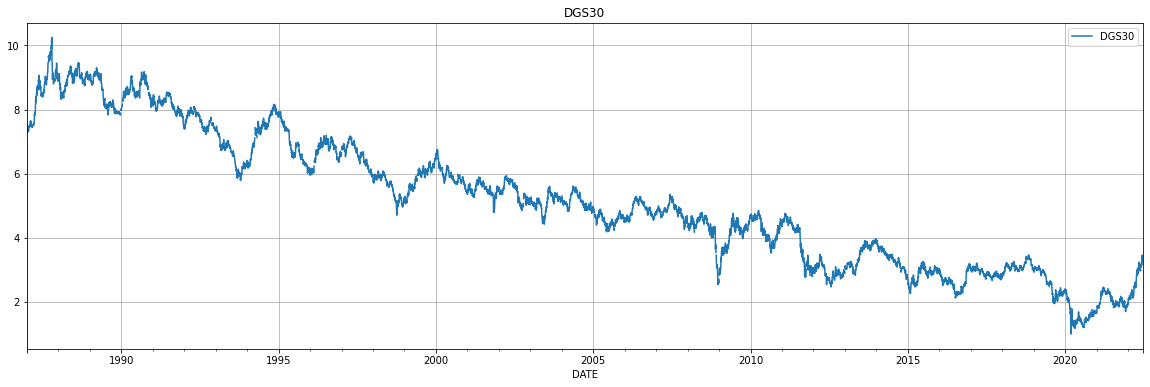

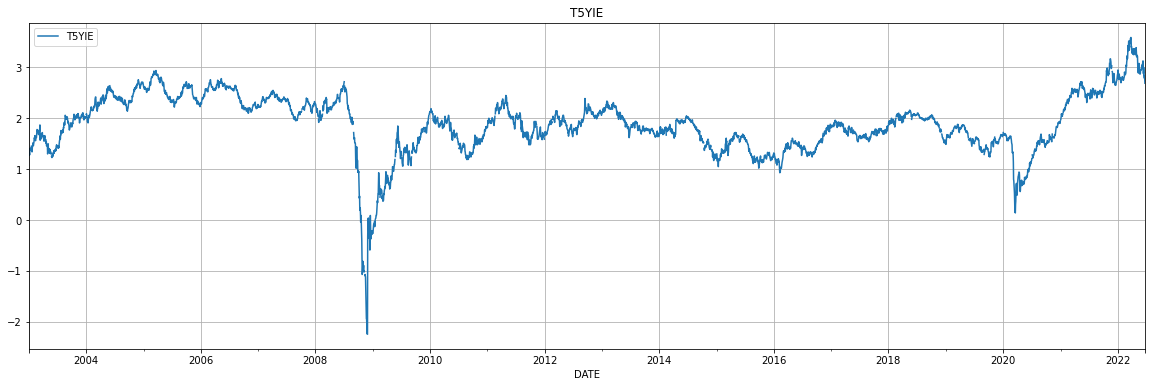

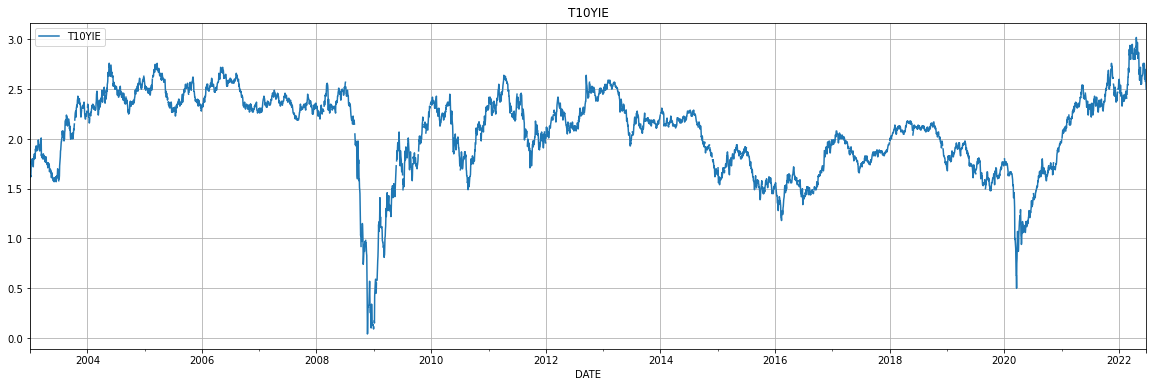

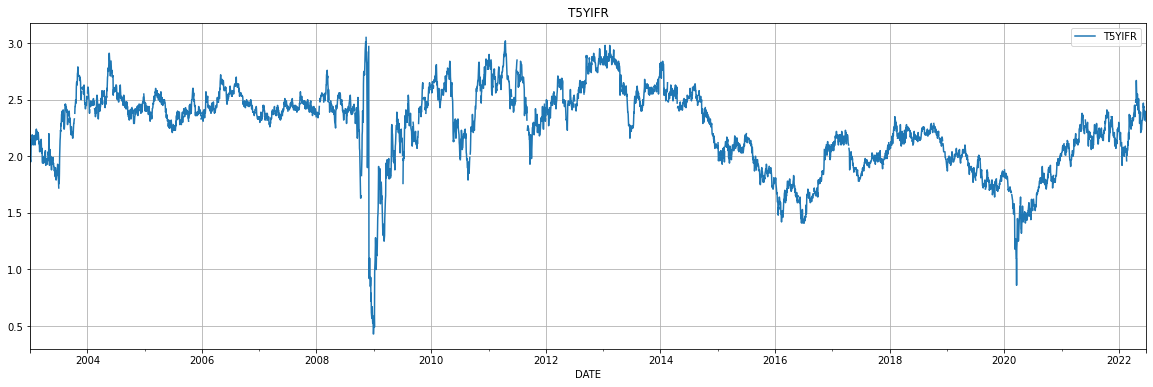

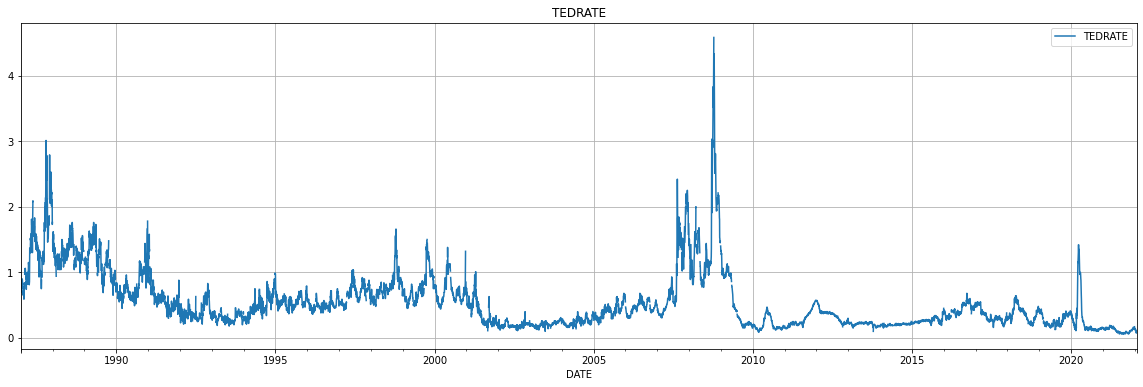

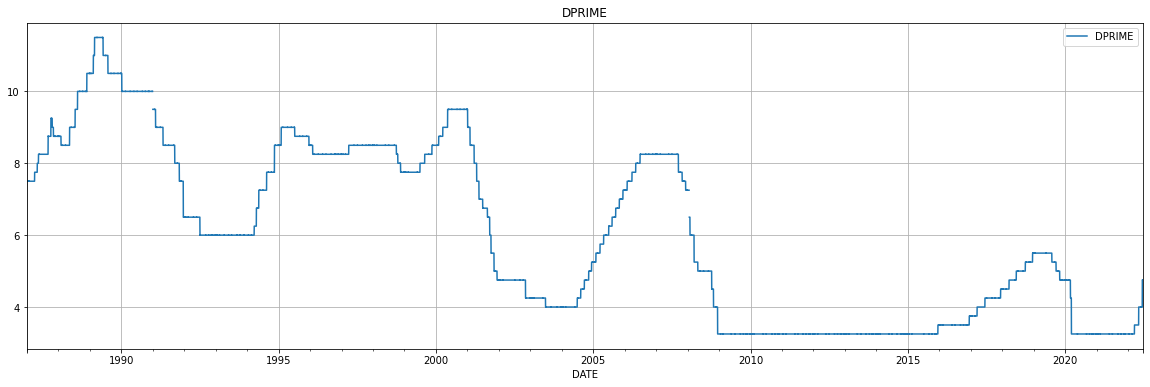

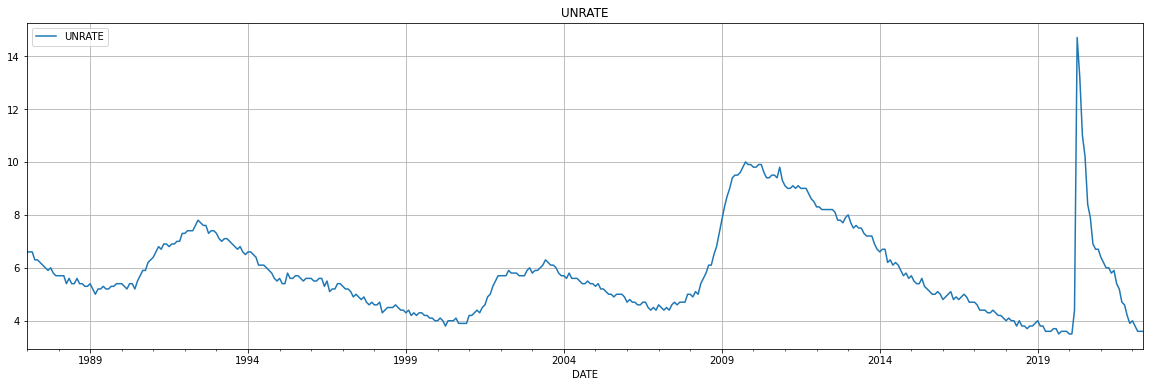

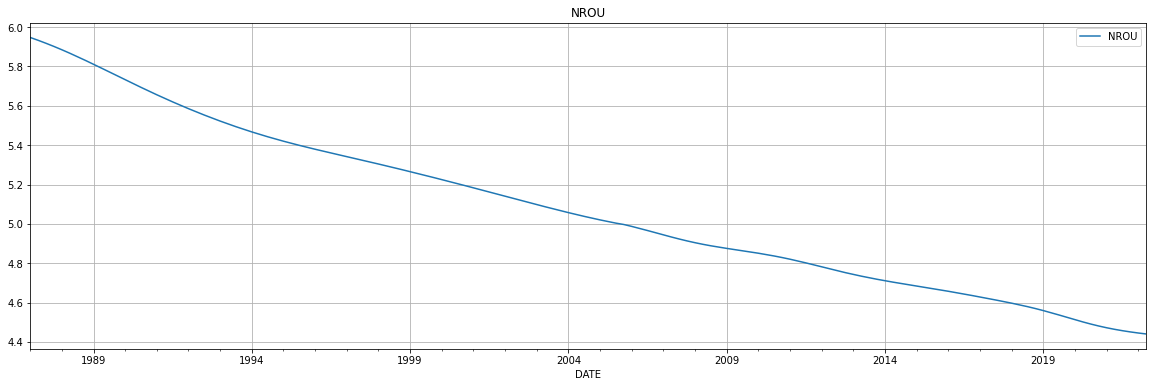

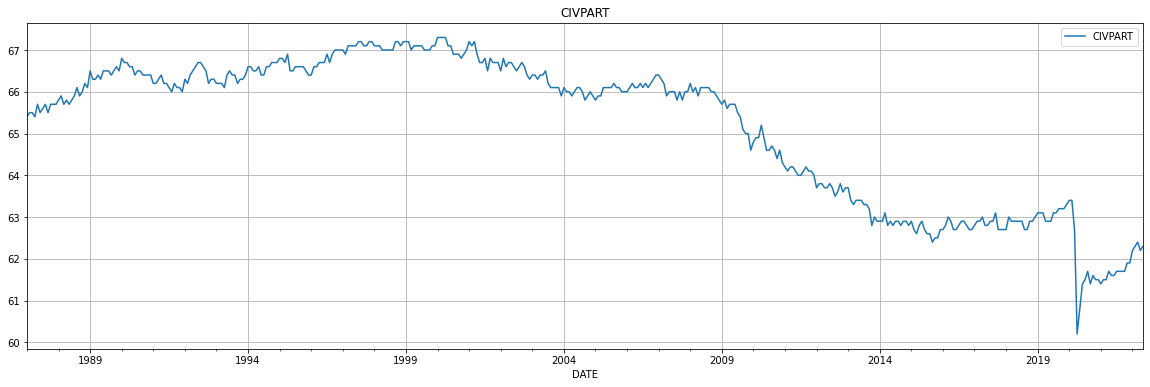

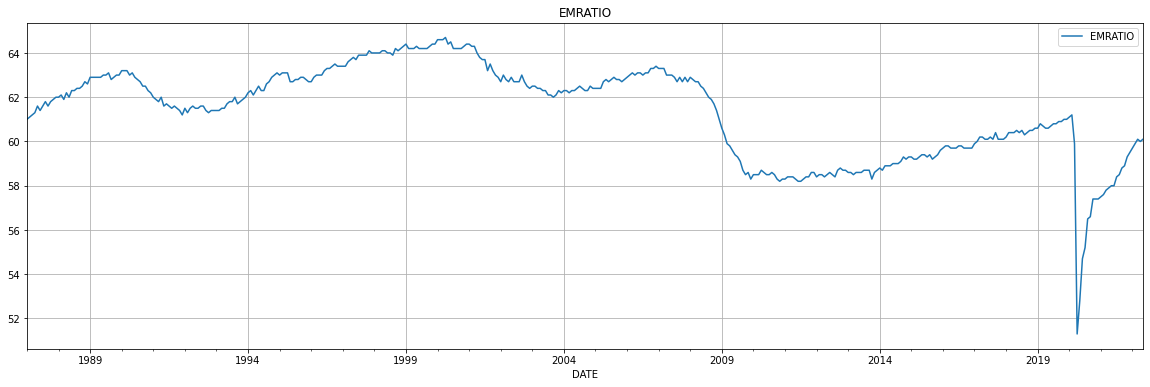

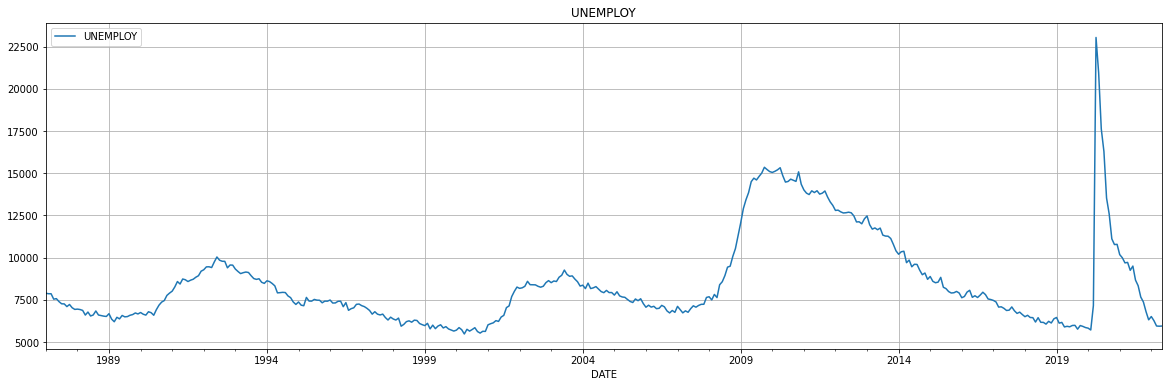

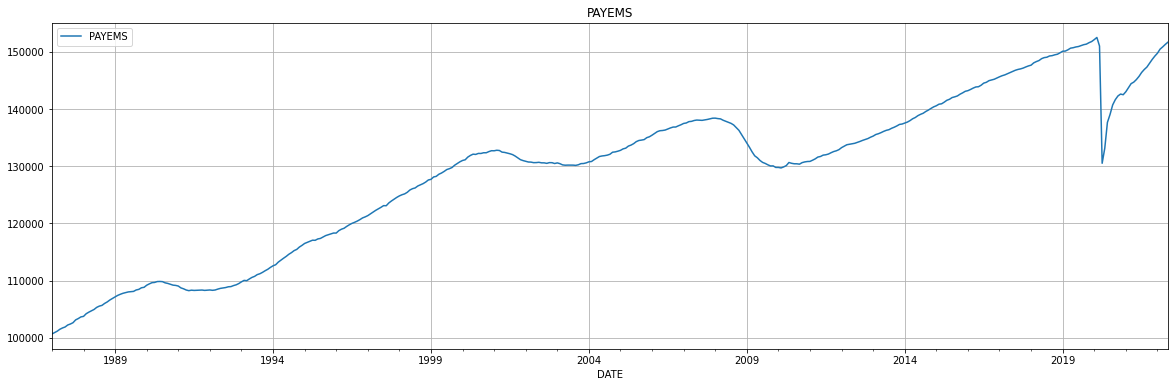

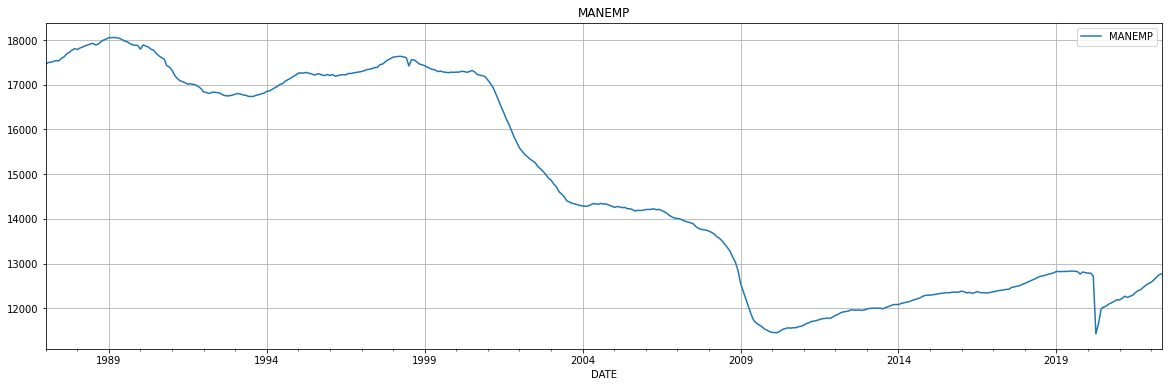

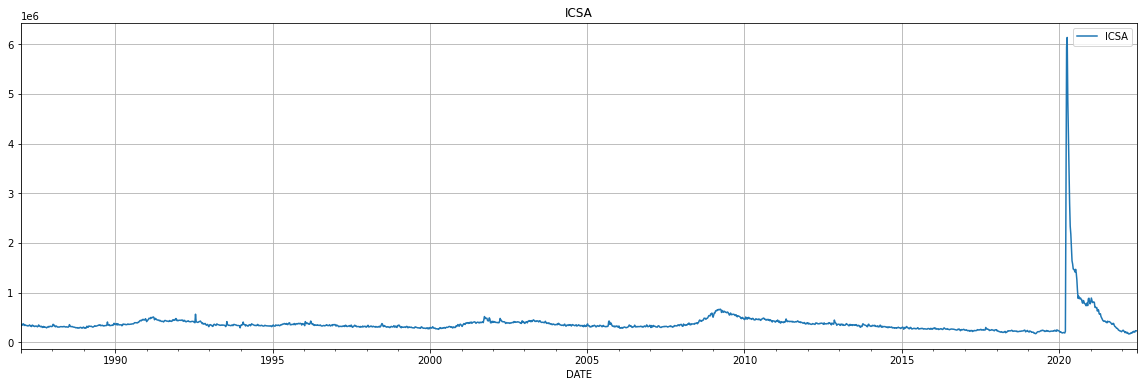

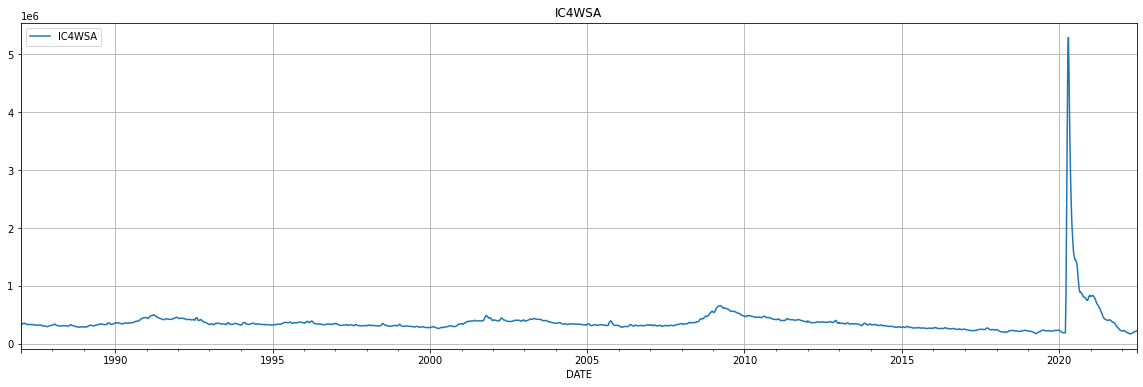

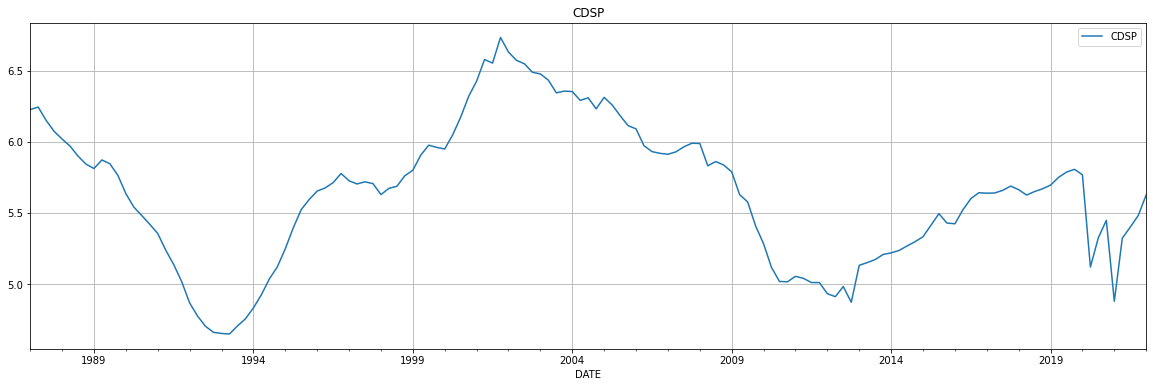

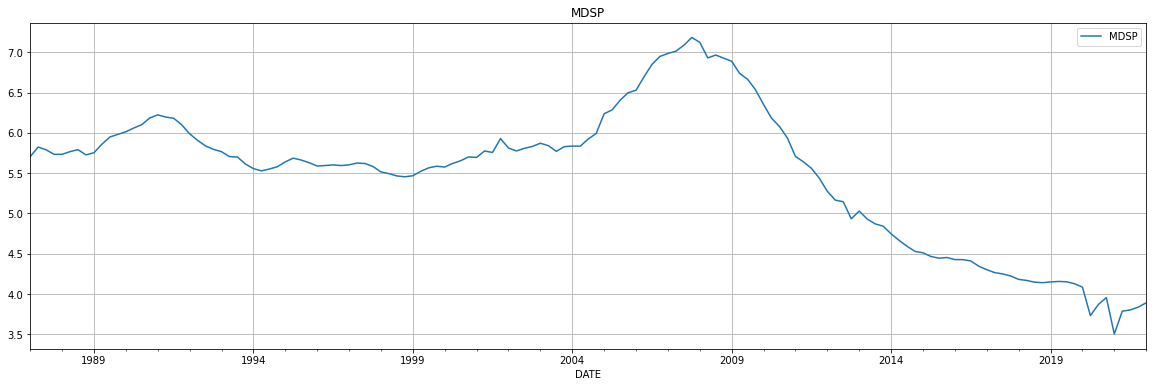

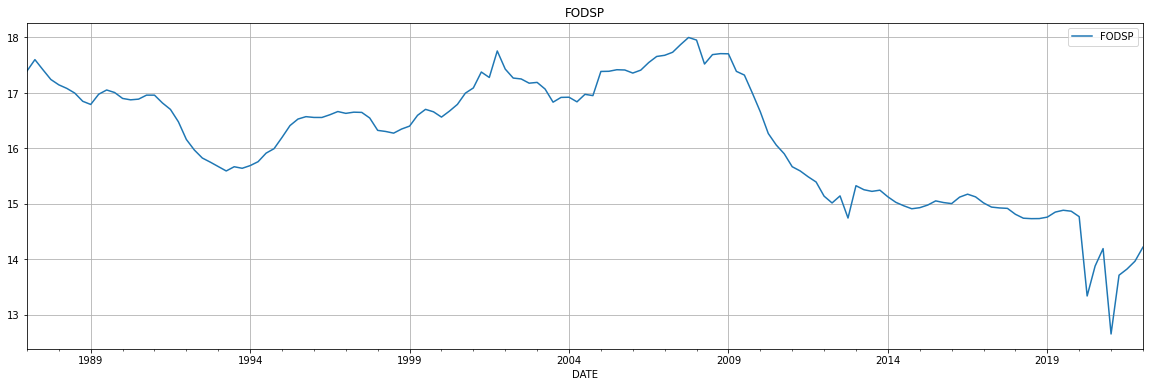

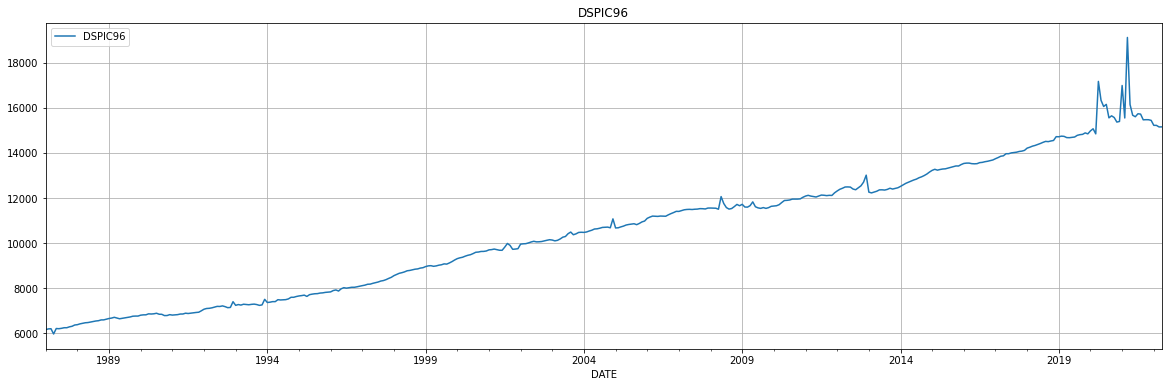

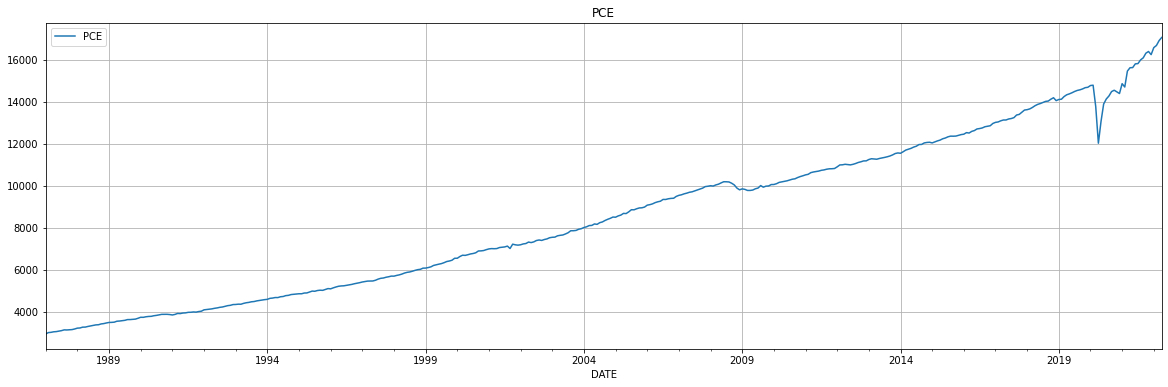

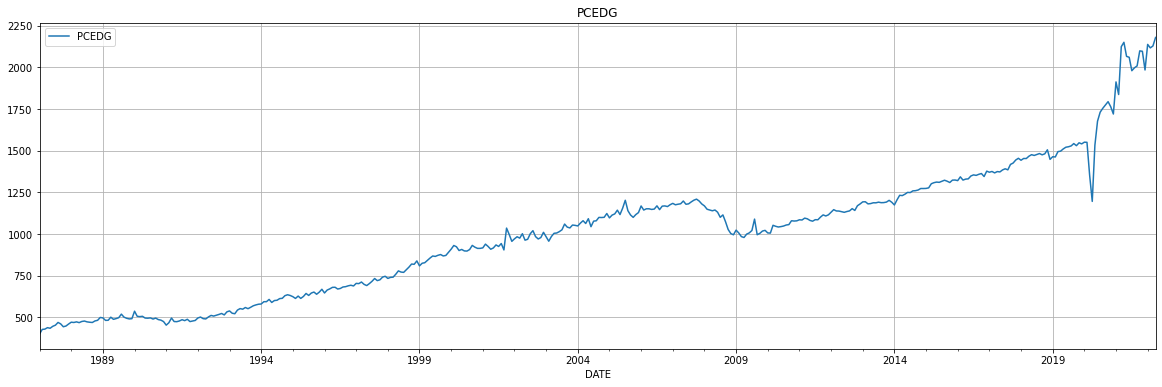

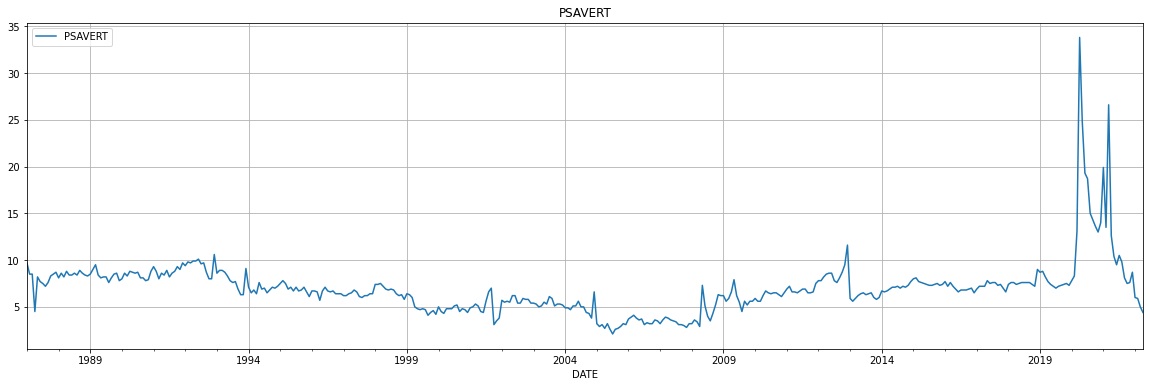

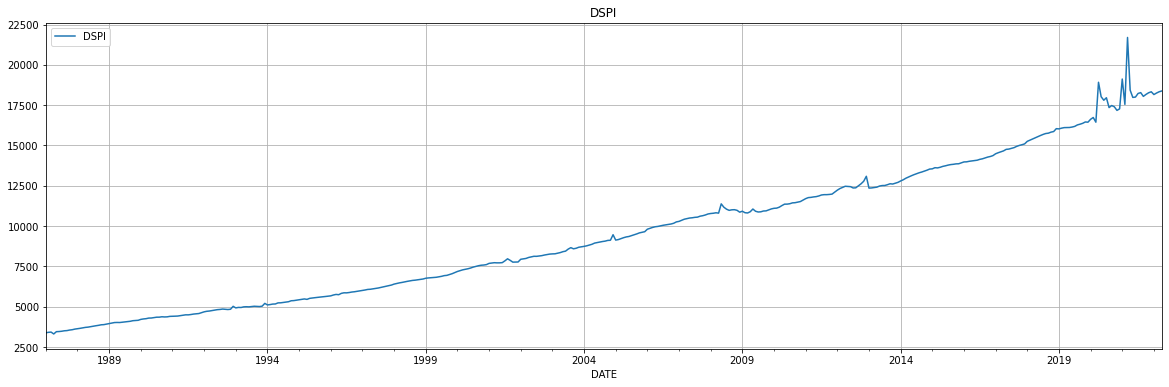

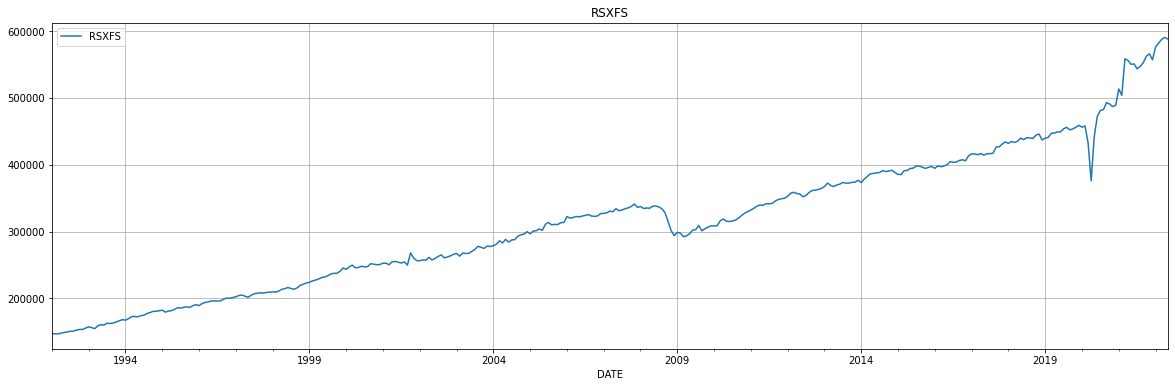

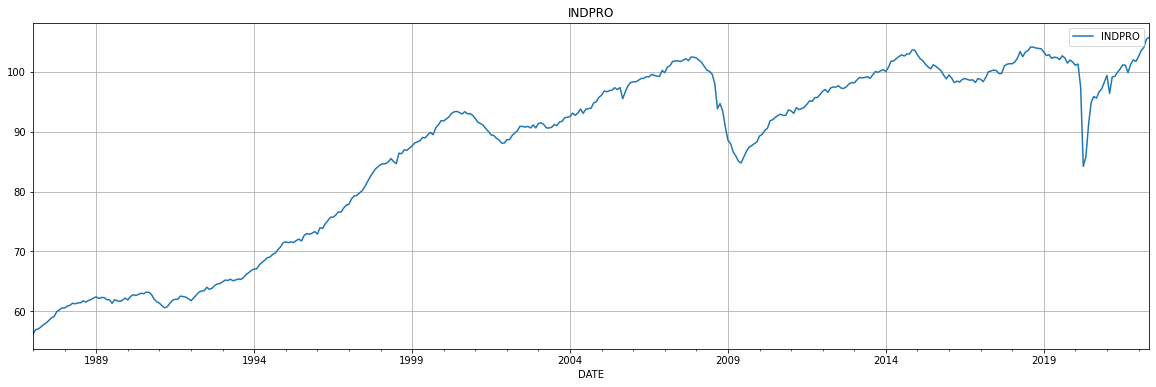

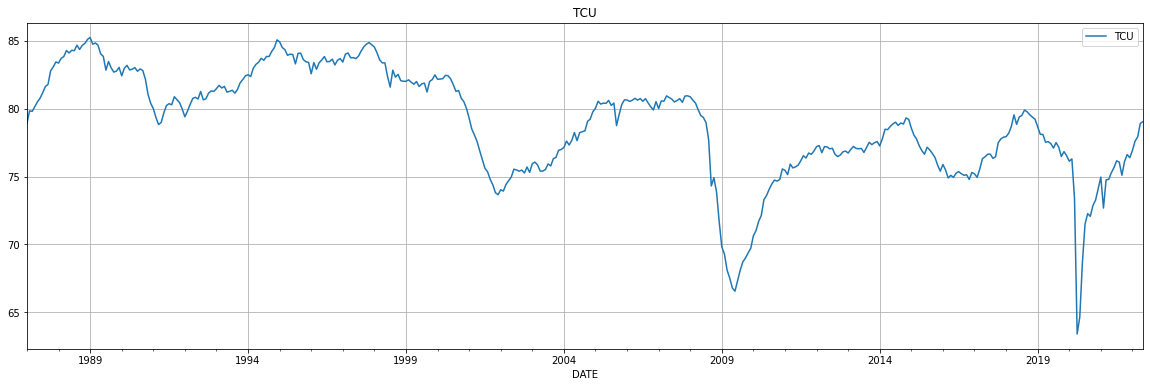

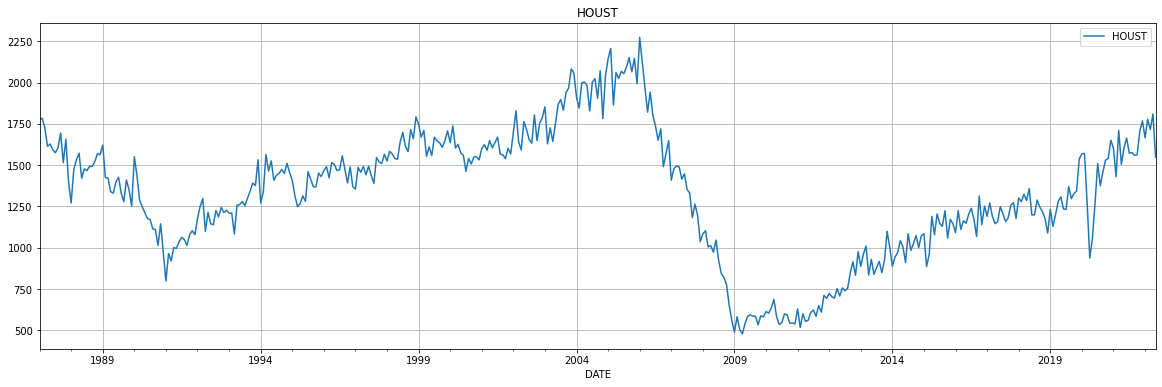

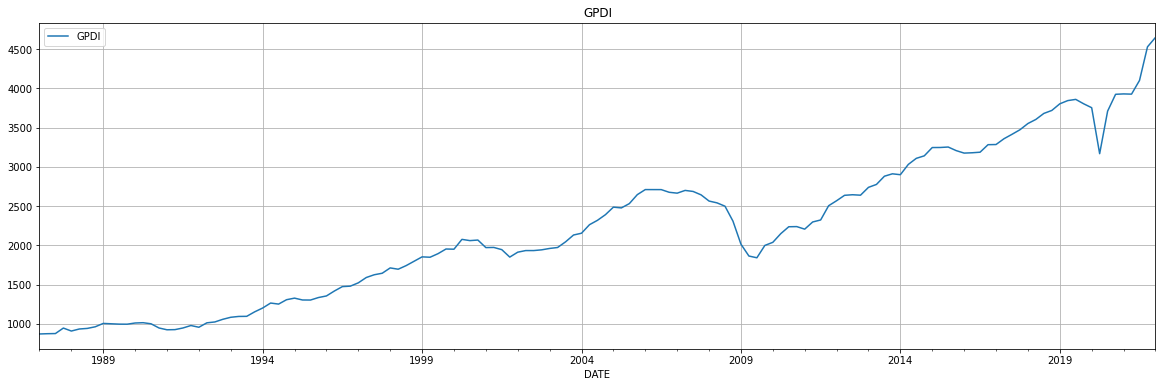

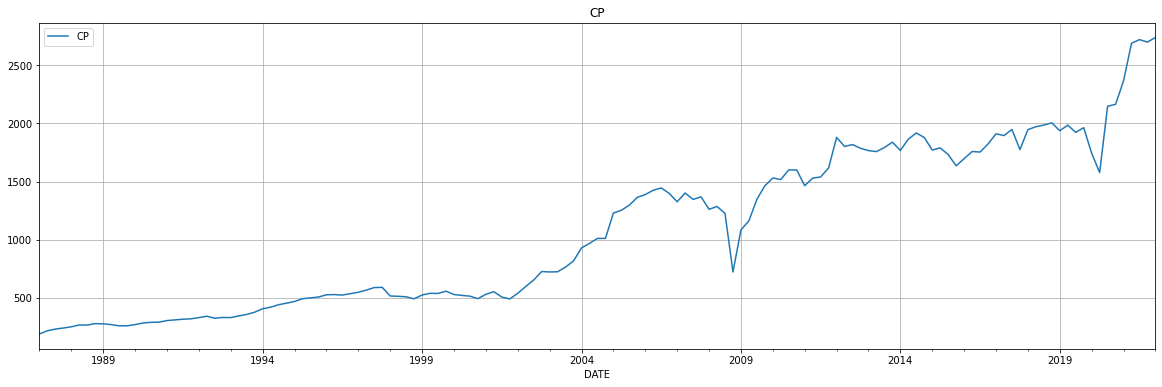

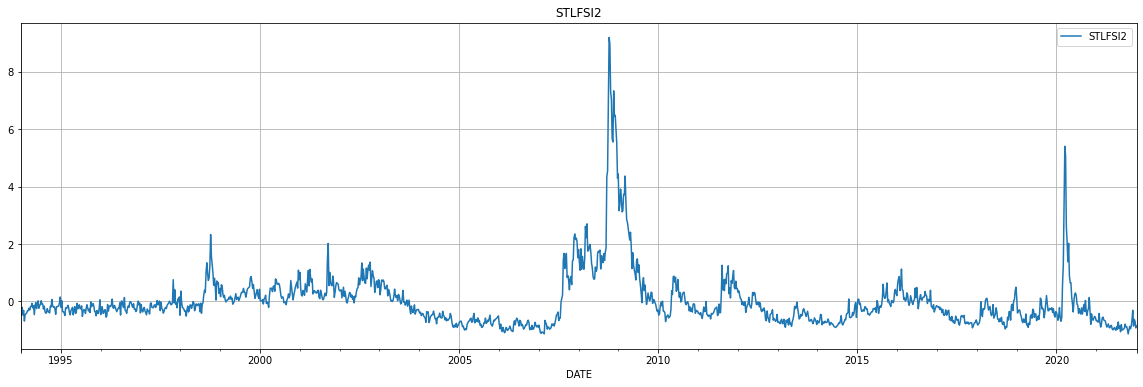

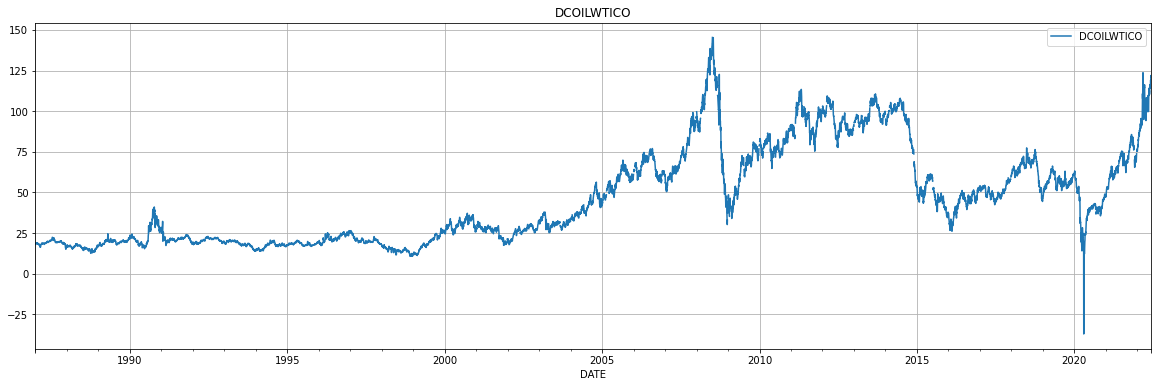

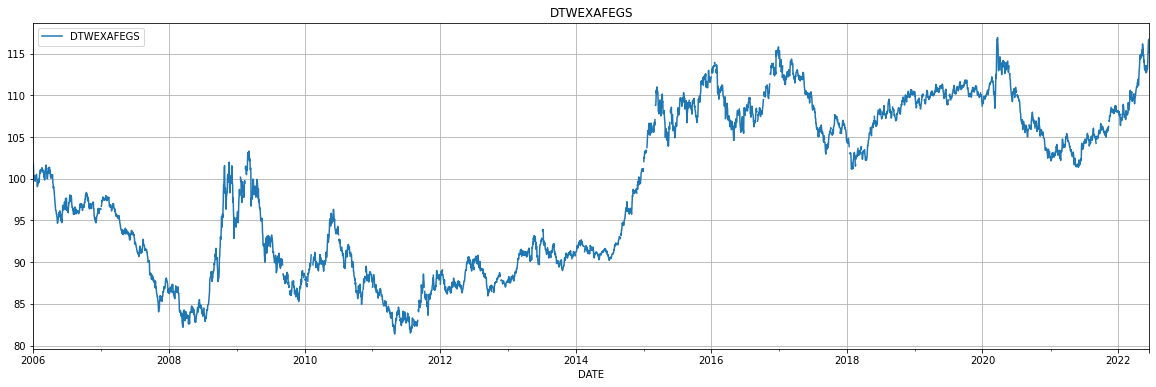

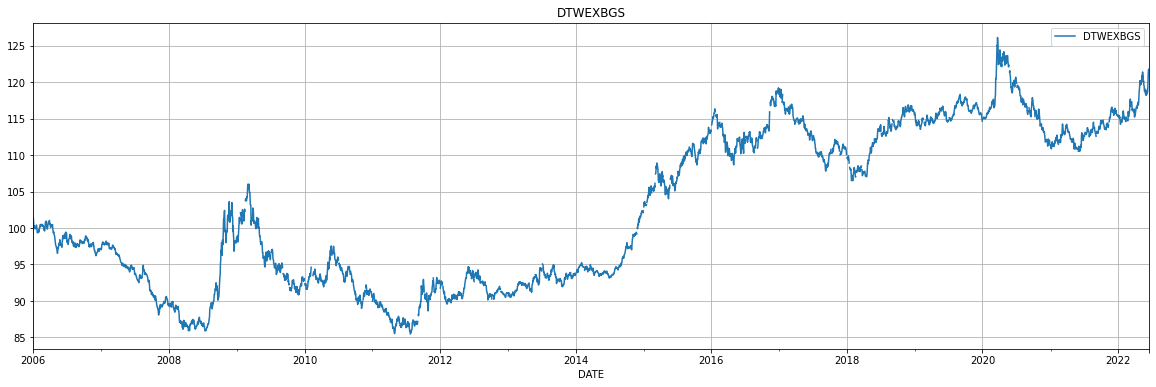

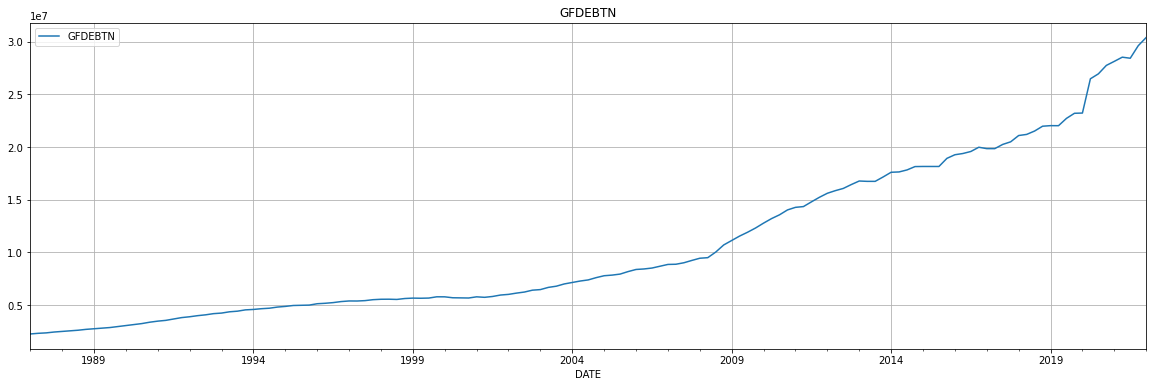

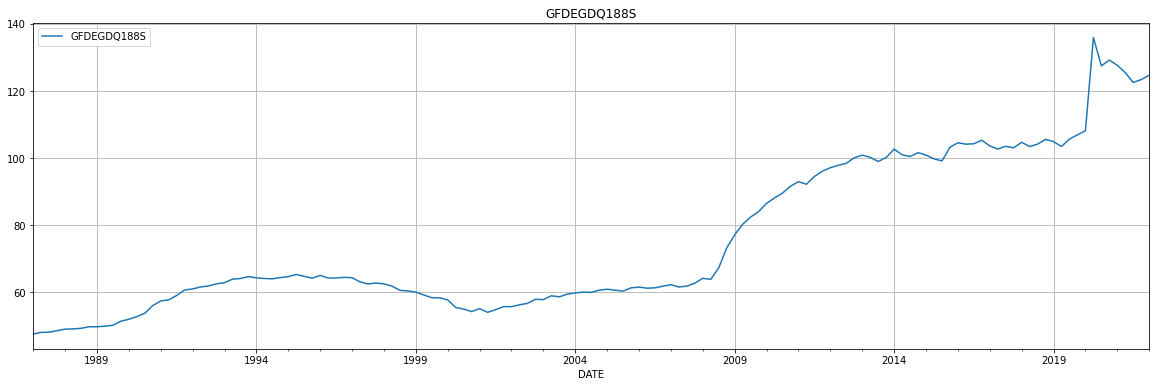

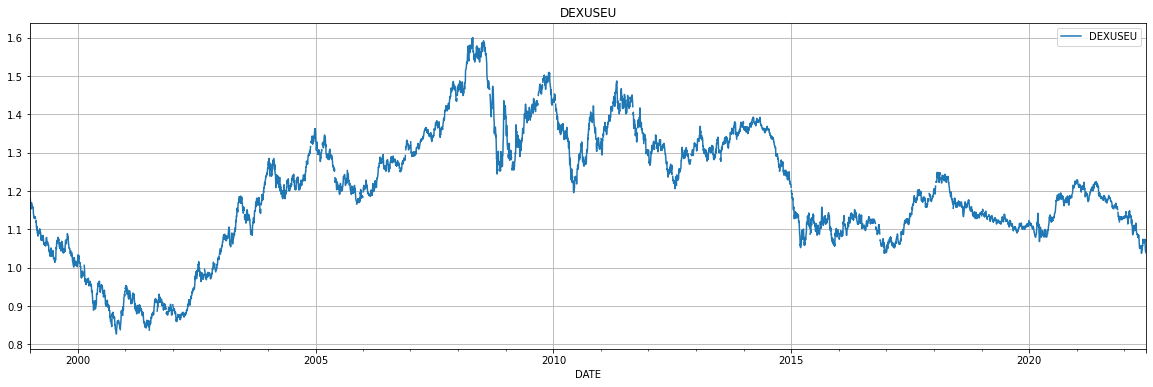

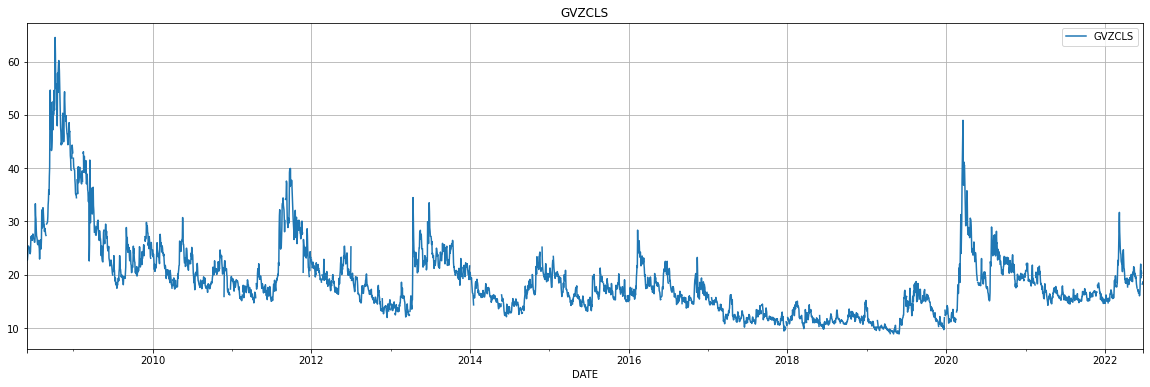

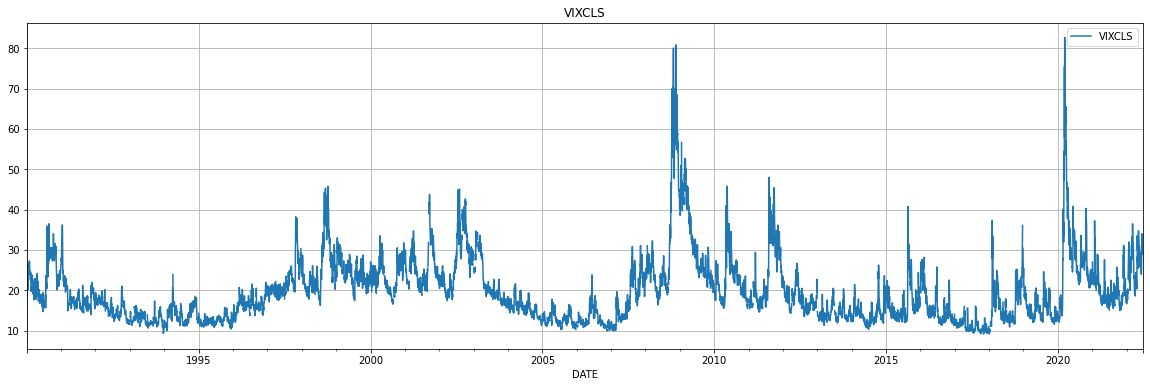

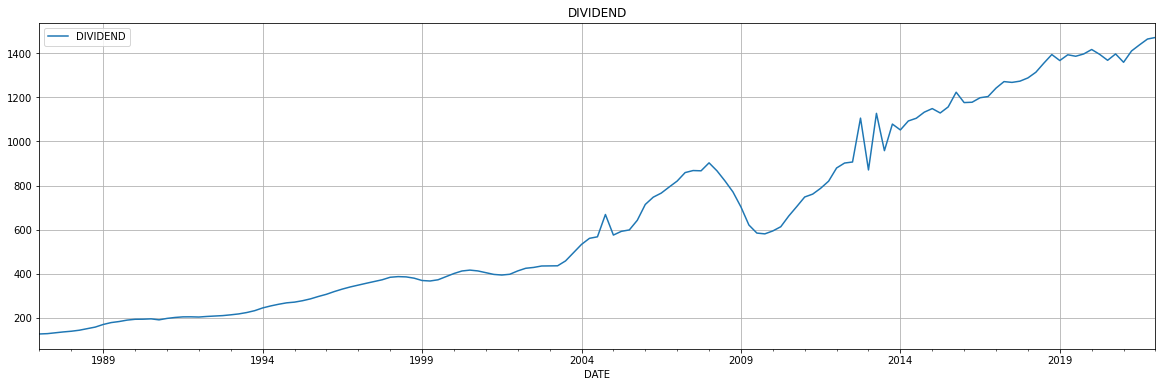

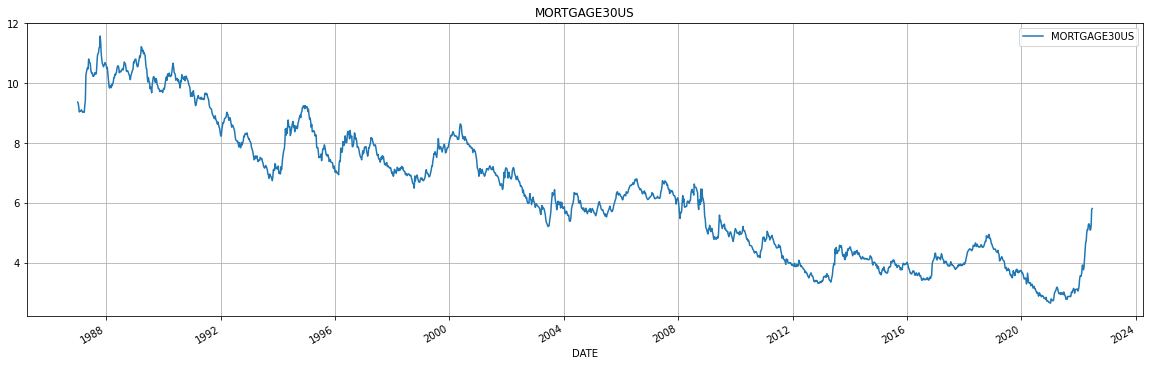

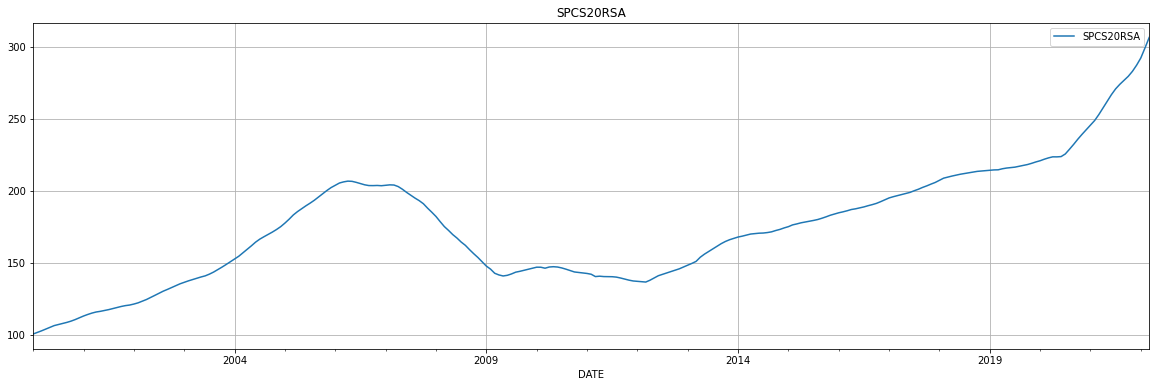

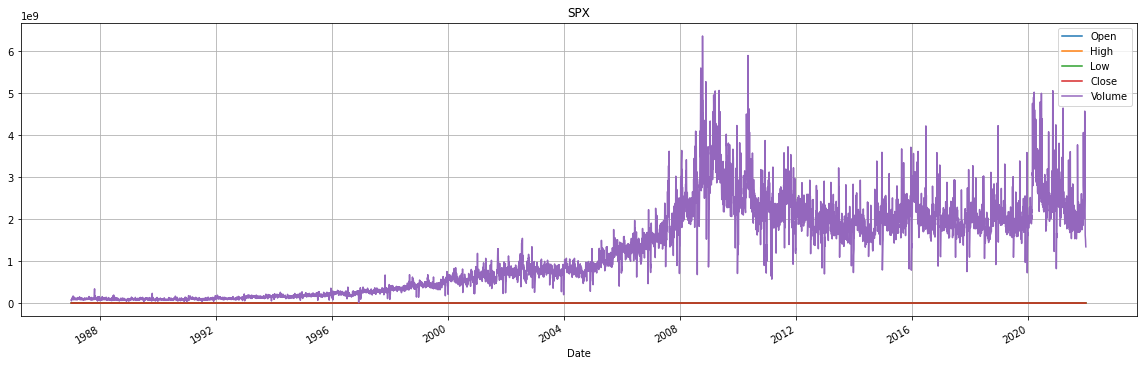

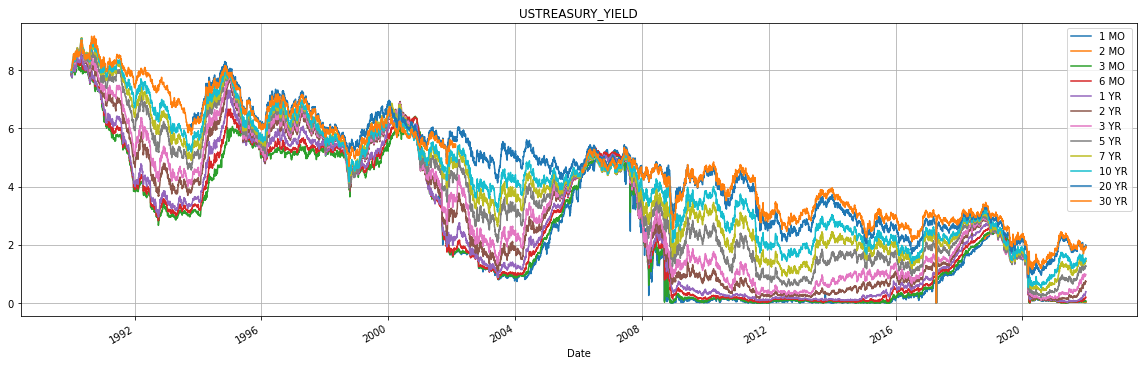

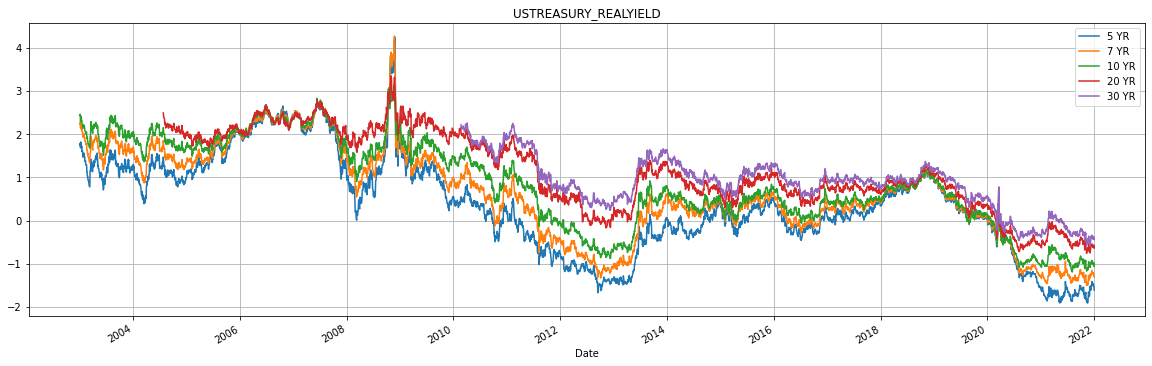

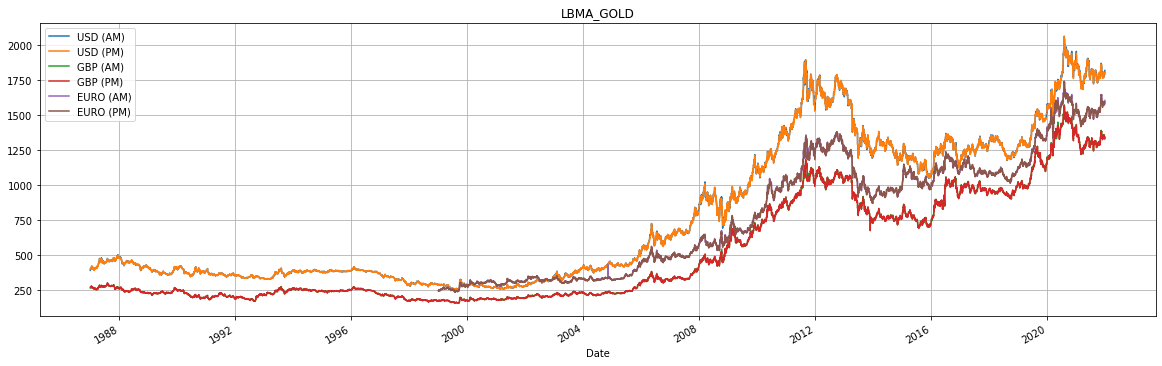

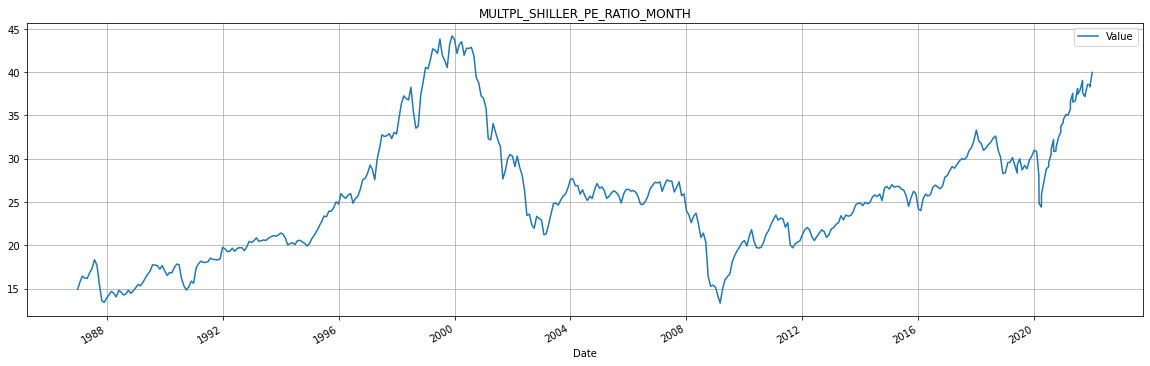

In [ ]:
for indicator in macro_indicators:

    macro_indicators[indicator].plot.line(figsize=(20,6), grid = True, title=f'{indicator}')

# **Section 3: Test Stationarity**

# **a.Plots:**

[*********************100%***********************]  1 of 1 completed


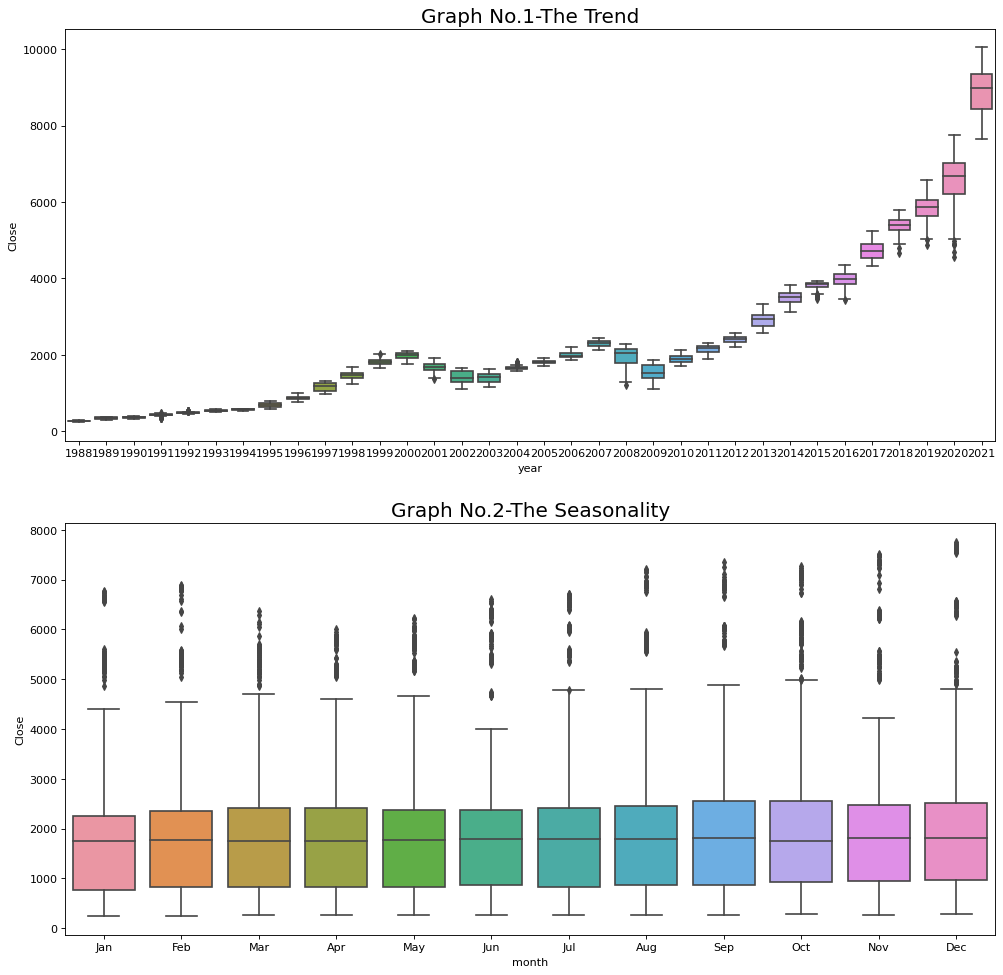

In [ ]:
df = yf.download('^SP500TR', start='1986-12-31', end='2021-12-31')
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])


df['year'] = [d.year for d in df.Date]
df['month'] = [d.strftime('%b') for d in df.Date]


years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(2, 1, figsize=(15,15), dpi= 80)
sns.boxplot(x='year', y='Close', data=df, ax=axes[0])
sns.boxplot(x='month', y='Close', data=df.loc[~df.year.isin([1986, 2021]), :])

# Set Title
axes[0].set_title('Graph No.1-The Trend', fontsize=18); 
axes[1].set_title('Graph No.2-The Seasonality', fontsize=18)
plt.show()

# **b. Summary Statistics**

In [ ]:
X = df.Close.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f\nmean2=%f' % (mean1, mean2))
print('variance1=%f\nvariance2=%f' % (var1, var2))

mean1=1004.646594
mean2=3626.961693
variance1=331248.414389
variance2=4082019.242430


# **c. Augmented Dickey-Fuller test**


In [ ]:
X = df.Close.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 5.039421
p-value: 1.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


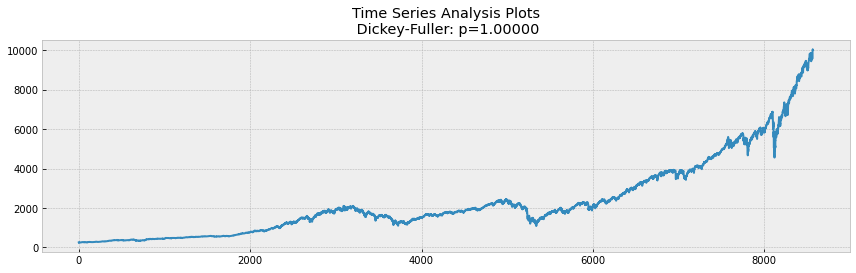

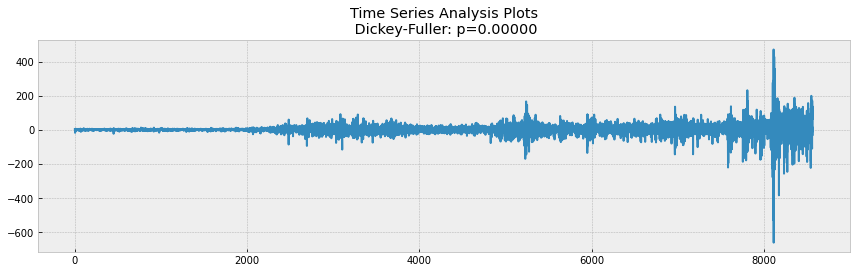

In [ ]:
def tsplot(y, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,1)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))

        plt.tight_layout()
        
tsplot(df['Close'])

data_diff = df['Close'] - df['Close'].shift(1)

tsplot(data_diff[1:])

# **Section 4: Achieve Stationarity:**

In [ ]:
# need to have a deep copy of macro indicators to make local transformations not changing the datarepo
macro_indicators_dict = copy.deepcopy(macro_indicators)

In [ ]:
#By Differencing Transformation: DoD, WoW, MoM, YoY growth

def get_macro_shift_transformation(macro_indicators_dict):
        """Add shifted (growth) values to the data_repo.macro_indicators before joining them together, remove non-stationary time series"""
        
        # Transform daily stats on this shift
        HISTORICAL_PERIODS_DAYS = [1, 3, 7, 30, 90, 365]
        
        # Different types of transformations for daily, weekly, monthly, indicators
        DoD_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'D']
        WoW_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'W']
        MoM_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'M']
        QoQ_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'Q']
        YoY_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'Y']

        # rename and drop some columns (especially from QUANDL)
       
        macro_indicators_dict['MULTPL_SHILLER_PE_RATIO_MONTH'].rename(
            columns={'Value': 'MULTPL_SHILLER_PE_RATIO_MONTH'}, inplace=True)
        #  GOLD PRICE == evening (PM) value in USD on London Stock Exchange, drop all other columns
        macro_indicators_dict['LBMA_GOLD'].rename(
            columns={'USD (PM)': 'LBMA_GOLD'}, inplace=True)
        macro_indicators_dict['LBMA_GOLD'].drop(
            ['USD (AM)', 'GBP (AM)', 'GBP (PM)', 'EURO (AM)', 'EURO (PM)'], axis=1, inplace=True)
        
        # INDEXES: leave only Close price
        macro_indicators_dict['SPX'].drop(
            ['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
        macro_indicators_dict['SPX'].rename(
            columns={'Close': 'SPX'}, inplace=True)
  

        for ind in DoD_ind:
            # do transform only if oil_prices, blockchain_prices, gold_prices, indexes
            if not ind in {'DCOILWTICO', 'LBMA_GOLD','SPX'}:
                continue
            # treat those as an index
            for i in HISTORICAL_PERIODS_DAYS:
                df = macro_indicators_dict[ind]
                ind_transformed = ind + '_growth_' + str(i)+'d'
                df[ind_transformed] = df[ind]/df[ind].shift(i)-1

        # future growth stats
        for ind in ['SPX']:
          for i in HISTORICAL_PERIODS_DAYS:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_future_growth_' + str(i)+'d'
            df[ind_transformed] = df[ind].shift(-i-1)/df[ind].shift(-1)-1

        for ind in WoW_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_wow'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_mom'
            df[ind_transformed] = df[ind]/df[ind].shift(5)-1
            # drop original "ind" column if series are non-stationary
            # do not drop original ind for FinStressIndex (STLFSI2), and Long-term Mortgage rates
            if not ind in {'STLFSI2', 'MORTGAGE30US'}:
                macro_indicators_dict[ind].drop(
                    [ind], axis=1, inplace=True)

        for ind in MoM_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_mom'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(12)-1
            # drop original "ind" column if series are non-stationary
            # do not drop original ind for all indicators that are 'ratios' or 'percentages'
            if not ind in {'UNRATE', 'CIVPART', 'EMRATIO', 'PSAVERT', 'INDPRO', 'TCU', 'SPCS20RSA', 'MULTPL_SHILLER_PE_RATIO_MONTH'}:
                macro_indicators_dict[ind].drop(
                    [ind], axis=1, inplace=True)

        # create one field as div_ratio (% of profits paid as dividents)
        macro_indicators_dict['CP'] = macro_indicators_dict['CP'].join(
            macro_indicators_dict['DIVIDEND'])
        macro_indicators_dict['CP']['div_ratio'] = macro_indicators_dict['CP']['DIVIDEND'] / \
            macro_indicators_dict['CP']['CP']
        macro_indicators_dict['CP'].drop(
            ['DIVIDEND'], axis=1, inplace=True)

        for ind in QoQ_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_qoq'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(4)-1
            # drop original "ind" column if series are non-stationary
            # do not drop original ind for all indicators that are 'ratios' or 'percentages'
            if not ind in {'GDPDEF', 'M1V', 'M2V', 'NROU', 'CDSP', 'MDSP', 'FODSP', 'GFDEGDQ188S'}:
                macro_indicators_dict[ind].drop(
                    [ind], axis=1, inplace=True)

        for ind in YoY_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            macro_indicators_dict[ind].drop([ind], axis=1, inplace=True)

In [ ]:
get_macro_shift_transformation(macro_indicators_dict)

In [ ]:
# Daily Transformation
macro_indicators_dict['SPX'].tail(3)

SPX  SPX_growth_1d  SPX_growth_3d  SPX_growth_7d  \
Date                                                               
2021-12-29  4793.06       0.001402       0.014235       0.037315   
2021-12-30  4778.73      -0.002990      -0.002601       0.046127   
2021-12-31  4766.18      -0.002626      -0.004214       0.025155   

            SPX_growth_30d  SPX_growth_90d  SPX_growth_365d  \
Date                                                          
2021-12-29        0.023546        0.079112         0.473953   
2021-12-30        0.016556        0.066793         0.467083   
2021-12-31        0.016531        0.062402         0.454869   

            SPX_future_growth_1d  SPX_future_growth_3d  SPX_future_growth_7d  \
Date                                                                           
2021-12-29             -0.002626                   NaN                   NaN   
2021-12-30                   NaN                   NaN                   NaN   
2021-12-31                   NaN                   NaN                   NaN   

            SPX_future_growth_30d  SPX_future_growth_90d  \
Date                                                       
2021-12-29                    NaN                    NaN   
2021-12-30                    NaN                    NaN   
2021-12-31                    NaN                    NaN   

            SPX_future_growth_365d  
Date                                
2021-12-29                     NaN  
2021-12-30                     NaN  
2021-12-31                     NaN

Text(0.5, 1.0, 'S&P current growth 365days ')

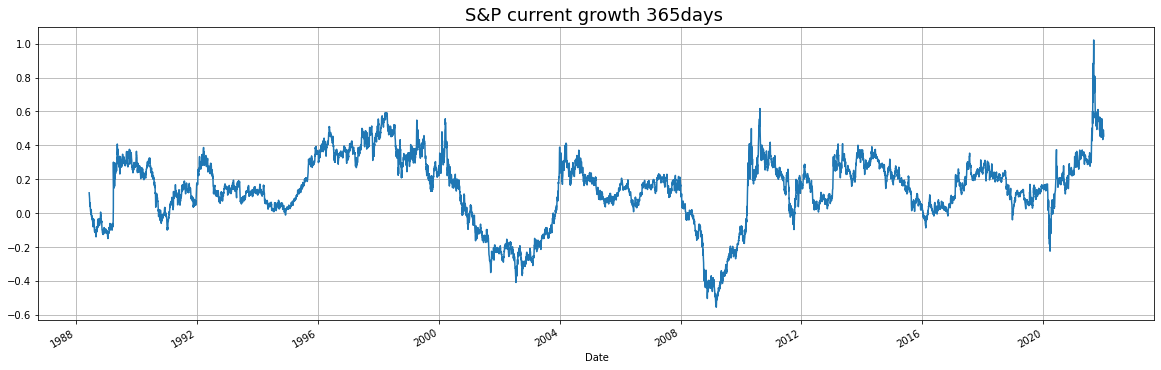

In [ ]:
macro_indicators_dict['SPX']['SPX_growth_365d'].plot.line(figsize=(20,6), grid = True)
plt.title('S&P current growth 365days ',fontsize=18)

Text(0.5, 1.0, 'Graph No.3- S&P current growth 90days Differencing')

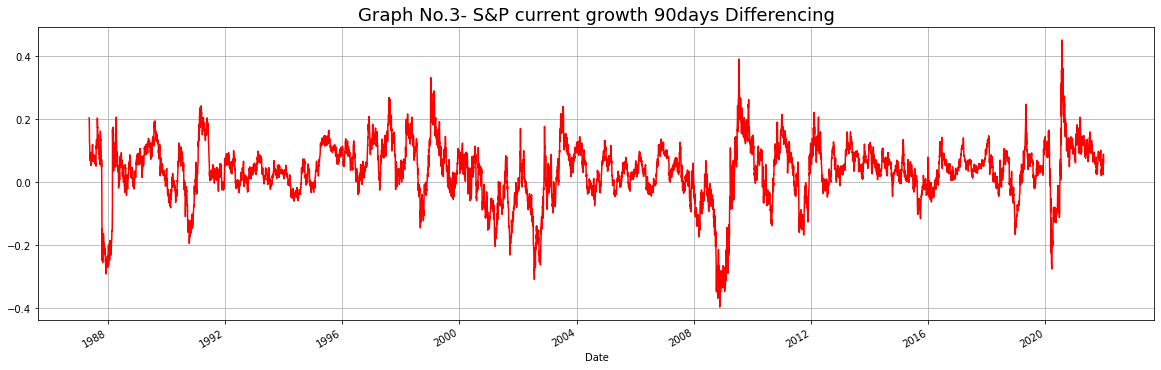

In [ ]:
macro_indicators_dict['SPX']['SPX_growth_90d'].plot.line(figsize=(20,6), grid = True,color='red')
plt.title('Graph No.3- S&P current growth 90days Differencing',fontsize=18)

Text(0.5, 1.0, 'S&P current growth 30days Differencing')

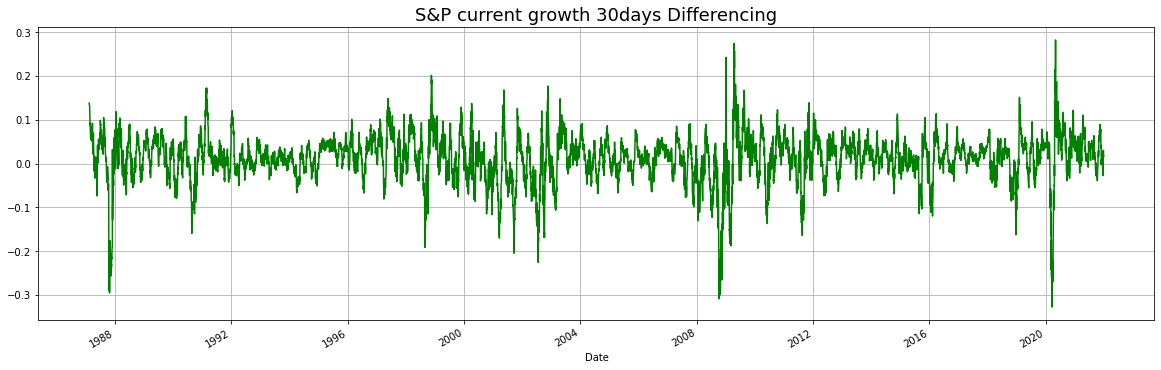

In [ ]:
macro_indicators_dict['SPX']['SPX_growth_30d'].plot.line(figsize=(20,6), grid = True,color='green')
plt.title('S&P current growth 30days Differencing',fontsize=18)

In [ ]:
# Quarterly Transformation
macro_indicators_dict['GDP'].tail(3)

GDP_qoq   GDP_yoy
DATE                          
2021-07-01  0.020289  0.097631
2021-10-01  0.034500  0.117575
2022-01-01  0.015893  0.106454

In [ ]:
# Yearly Transformation
macro_indicators_dict['CP'].tail(3)

div_ratio    CP_qoq    CP_yoy
DATE                                     
2021-07-01   0.528627  0.011602  0.266947
2021-10-01   0.542580 -0.007817  0.247577
2022-01-01   0.537322  0.014731  0.157337

In [ ]:
# Monthly Transformation
macro_indicators_dict['DSPIC96'].tail(3)

DSPIC96_mom  DSPIC96_yoy
DATE                                
2022-02-01    -0.000112    -0.021089
2022-03-01    -0.004573    -0.207579
2022-04-01     0.000165    -0.061541

In [ ]:
# Weekly transformation
macro_indicators_dict['MORTGAGE30US'].tail(3)

MORTGAGE30US  MORTGAGE30US_wow  MORTGAGE30US_mom
DATE                                                        
2022-06-09          5.23          0.027505         -0.007590
2022-06-16          5.78          0.105163          0.090566
2022-06-23          5.81          0.005190          0.106667

# **Section 5: Join all the variables to one**

In [ ]:
dates = pd.DataFrame(macro_indicators_dict['SPX'].index.sort_values().unique(), columns=['Date'])
dates

Date
0    1986-12-31
1    1987-01-02
2    1987-01-05
3    1987-01-06
4    1987-01-07
...         ...
8818 2021-12-27
8819 2021-12-28
8820 2021-12-29
8821 2021-12-30
8822 2021-12-31

[8823 rows x 1 columns]

In [ ]:
def get_daily_macro_stats_df(daily_df, macro_ind_df, regime='LAST'):
        """take Time from daily_df, and apply that to macro_ind_df, (LAST=take last observation, PREVIOUS=take previous) """
        ticker_dates = daily_df.Date.sort_values().unique()
        new_column_dict = {}

        for elem in ticker_dates:
            ts = pd.to_datetime(str(elem))
            d = ts.strftime('%Y-%m-%d')
            # all potential records to merge
            options_to_merge = macro_ind_df[macro_ind_df.index <= d]
            if len(options_to_merge) == 0:
                continue
            last_value = options_to_merge.tail(1).values.tolist()[0]
            prev_value = options_to_merge.tail(2).values.tolist()[0]
            if regime == 'PREVIOUS':
                if prev_value is not None:
                    new_column_dict[d] = prev_value
            elif regime == 'LAST':
                if last_value is not None:
                    new_column_dict[d] = last_value
            else:
                raise("Regime should be in ('PREVIOUS','LAST')")
        return pd.DataFrame.from_dict(new_column_dict, orient='index', columns = options_to_merge.keys())

In [ ]:
# 2) Create a DAILY macro stats dataset
# Different types of joins for daily, weekly, monthly, indicators
  # join on the last available date
lastday_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v not in ('M', 'Q', 'Y')]
  # join on the previous available date (M,Q,Y stats write say '2021-01-01' - but they represent the whole M,Q,Y STARTING at this date)
firstday_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v in ('M', 'Q', 'Y')]

  # start from all dates we need to have macro stats
dates = pd.DataFrame(macro_indicators_dict['SPX'].index.sort_values().unique(), columns=['Date'])

macro_data_df = None
#  iterate over all transformed series in self.macro_indicators_dict and join one by one
# all non-Monthly indicators are
tq_last_day = tqdm(lastday_ind)
tq_last_day.set_description("Merging LAST Day indicators")
for ind in tq_last_day:
  # do not add some indicators to the final dataset (they are duplicated in another datasource)
  if ind in ('USTREASURY_YIELD', 'USTREASURY_REALYIELD'):
    continue
  df_to_merge = get_daily_macro_stats_df(dates, macro_indicators_dict[ind], regime='LAST')
  if macro_data_df is None:
    macro_data_df = df_to_merge
  else:
    macro_data_df = macro_data_df.join(df_to_merge)

tq_first_day = tqdm(firstday_ind)
tq_first_day.set_description("Merging FIRST Day indicators")
#  some stats  have first day of period date (e.g. '2020-06-01' instead of '2020-06-30'), so we need to get PREVIOUS available macro param
for ind in tq_first_day:
  df_to_merge = get_daily_macro_stats_df(dates, macro_indicators_dict[ind], regime='PREVIOUS')
  if macro_data_df is None:
    macro_data_df = df_to_merge
  else:
    macro_data_df = macro_data_df.join(df_to_merge)

Merging FIRST Day indicators: 100%|██████████| 36/36 [02:31<00:00,  4.22s/it]


In [ ]:
macro_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8821 entries, 1987-01-05 to 2021-12-31
Columns: 146 entries, WM1NS_wow to MULTPL_SHILLER_PE_RATIO_MONTH_yoy
dtypes: float64(146)
memory usage: 10.1+ MB


In [ ]:
# save the data 
macro_data_df.to_csv('macro_data.csv')

In [ ]:
macro_df=pd.read_csv('macro_data.csv',index_col=0)
macro_df.head(3)

WM1NS_wow  WM1NS_mom  WM2NS_wow  WM2NS_mom  WALCL_wow  WALCL_mom  \
1987-01-05        NaN        NaN        NaN        NaN        NaN        NaN   
1987-01-06        NaN        NaN        NaN        NaN        NaN        NaN   
1987-01-07        NaN        NaN        NaN        NaN        NaN        NaN   

             DFF  DTB3  DGS5  DGS10  ...  GFDEGDQ188S_qoq  GFDEGDQ188S_yoy  \
1987-01-05  6.86  5.55  6.67   7.08  ...              NaN              NaN   
1987-01-06  6.56  5.51  6.67   7.08  ...              NaN              NaN   
1987-01-07  6.20  5.43  6.65   7.05  ...              NaN              NaN   

            DIVIDEND_qoq  DIVIDEND_yoy  SPCS20RSA  SPCS20RSA_mom  \
1987-01-05           NaN           NaN        NaN            NaN   
1987-01-06           NaN           NaN        NaN            NaN   
1987-01-07           NaN           NaN        NaN            NaN   

            SPCS20RSA_yoy  MULTPL_SHILLER_PE_RATIO_MONTH  \
1987-01-05            NaN                          14.92   
1987-01-06            NaN                          14.92   
1987-01-07            NaN                          14.92   

            MULTPL_SHILLER_PE_RATIO_MONTH_mom  \
1987-01-05                                NaN   
1987-01-06                                NaN   
1987-01-07                                NaN   

            MULTPL_SHILLER_PE_RATIO_MONTH_yoy  
1987-01-05                                NaN  
1987-01-06                                NaN  
1987-01-07                                NaN  

[3 rows x 146 columns]

In [ ]:
len(macro_df.keys())

146

# **Section 6: Correlation Analysis**

In [ ]:
macro_df.corr()

WM1NS_wow  WM1NS_mom  WM2NS_wow  WM2NS_mom  \
WM1NS_wow                           1.000000   0.460033   0.031836   0.149399   
WM1NS_mom                           0.460033   1.000000   0.051481   0.329101   
WM2NS_wow                           0.031836   0.051481   1.000000   0.524213   
WM2NS_mom                           0.149399   0.329101   0.524213   1.000000   
WALCL_wow                           0.041504   0.091935   0.105674   0.239543   
...                                      ...        ...        ...        ...   
SPCS20RSA_mom                      -0.003677  -0.018111  -0.001245  -0.034303   
SPCS20RSA_yoy                      -0.005349  -0.016630  -0.002905  -0.011465   
MULTPL_SHILLER_PE_RATIO_MONTH       0.003005   0.005023   0.038210   0.100788   
MULTPL_SHILLER_PE_RATIO_MONTH_mom   0.025442   0.057519  -0.018868  -0.040562   
MULTPL_SHILLER_PE_RATIO_MONTH_yoy  -0.019149  -0.045471  -0.020090  -0.073963   

                                   WALCL_wow  WALCL_mom       DFF      DTB3  \
WM1NS_wow                           0.041504   0.097848 -0.039972 -0.040847   
WM1NS_mom                           0.091935   0.166241 -0.089335 -0.089348   
WM2NS_wow                           0.105674   0.115608 -0.047979 -0.046621   
WM2NS_mom                           0.239543   0.359765 -0.122207 -0.131112   
WALCL_wow                           1.000000   0.652097 -0.064502 -0.080648   
...                                      ...        ...       ...       ...   
SPCS20RSA_mom                      -0.097574  -0.166499 -0.054161 -0.005575   
SPCS20RSA_yoy                      -0.118015  -0.175742  0.080158  0.131784   
MULTPL_SHILLER_PE_RATIO_MONTH      -0.075869  -0.125071 -0.119611 -0.107990   
MULTPL_SHILLER_PE_RATIO_MONTH_mom  -0.135241  -0.213680  0.011302  0.021817   
MULTPL_SHILLER_PE_RATIO_MONTH_yoy  -0.098155  -0.174192  0.087840  0.097201   

                                       DGS5     DGS10  ...  GFDEGDQ188S_qoq  \
WM1NS_wow                         -0.048892 -0.053172  ...         0.001994   
WM1NS_mom                         -0.107758 -0.116332  ...         0.013151   
WM2NS_wow                         -0.067371 -0.071110  ...        -0.010047   
WM2NS_mom                         -0.187479 -0.201386  ...         0.004088   
WALCL_wow                         -0.054362 -0.032309  ...         0.024224   
...                                     ...       ...  ...              ...   
SPCS20RSA_mom                      0.010780 -0.029330  ...        -0.214548   
SPCS20RSA_yoy                      0.122104  0.056190  ...        -0.294033   
MULTPL_SHILLER_PE_RATIO_MONTH     -0.249748 -0.338208  ...        -0.284990   
MULTPL_SHILLER_PE_RATIO_MONTH_mom  0.015624  0.010971  ...         0.016231   
MULTPL_SHILLER_PE_RATIO_MONTH_yoy  0.076980  0.064866  ...        -0.229263   

                                   GFDEGDQ188S_yoy  DIVIDEND_qoq  \
WM1NS_wow                                 0.007552     -0.010769   
WM1NS_mom                                 0.019436     -0.021024   
WM2NS_wow                                -0.003577     -0.013720   
WM2NS_mom                                 0.005139     -0.040550   
WALCL_wow                                 0.031448     -0.052948   
...                                            ...           ...   
SPCS20RSA_mom                            -0.106188      0.083640   
SPCS20RSA_yoy                            -0.389638      0.215383   
MULTPL_SHILLER_PE_RATIO_MONTH            -0.449649     -0.021205   
MULTPL_SHILLER_PE_RATIO_MONTH_mom         0.097209     -0.018169   
MULTPL_SHILLER_PE_RATIO_MONTH_yoy        -0.066033      0.189450   

                                   DIVIDEND_yoy  SPCS20RSA  SPCS20RSA_mom  \
WM1NS_wow                             -0.014446   0.041693      -0.003677   
WM1NS_mom                             -0.032568   0.095362      -0.018111   
WM2NS_wow                             -0.004254   0.046308      -0.001245   
WM2NS_mom                             -

# **a.Correlations between current changes of S&P index and current changes of economic indicators**

In [ ]:
SPX_growth_365d_corr = pd.DataFrame(macro_df.corr()['SPX_growth_365d'].sort_values())
SPX_growth_365d_corr.head(10)

SPX_growth_365d
GVZCLS                 -0.574086
STLFSI2                -0.533515
VIXCLS                 -0.412140
FODSP                  -0.365115
M1V                    -0.329735
CDSP                   -0.318243
MDSP                   -0.314536
UNEMPLOY_yoy           -0.311562
GFDEGDQ188S_yoy        -0.300461
UNRATE_yoy             -0.299349

In [ ]:
SPX_growth_365d_corr.tail(10)

SPX_growth_365d
TCU_yoy                                   0.452138
SPX_growth_90d                            0.477265
T10YIE                                    0.480776
RSXFS_yoy                                 0.513797
T5YIE                                     0.520571
GPDI_yoy                                  0.559701
MANEMP_yoy                                0.572285
INDPRO_yoy                                0.577354
MULTPL_SHILLER_PE_RATIO_MONTH_yoy         0.752909
SPX_growth_365d                           1.000000

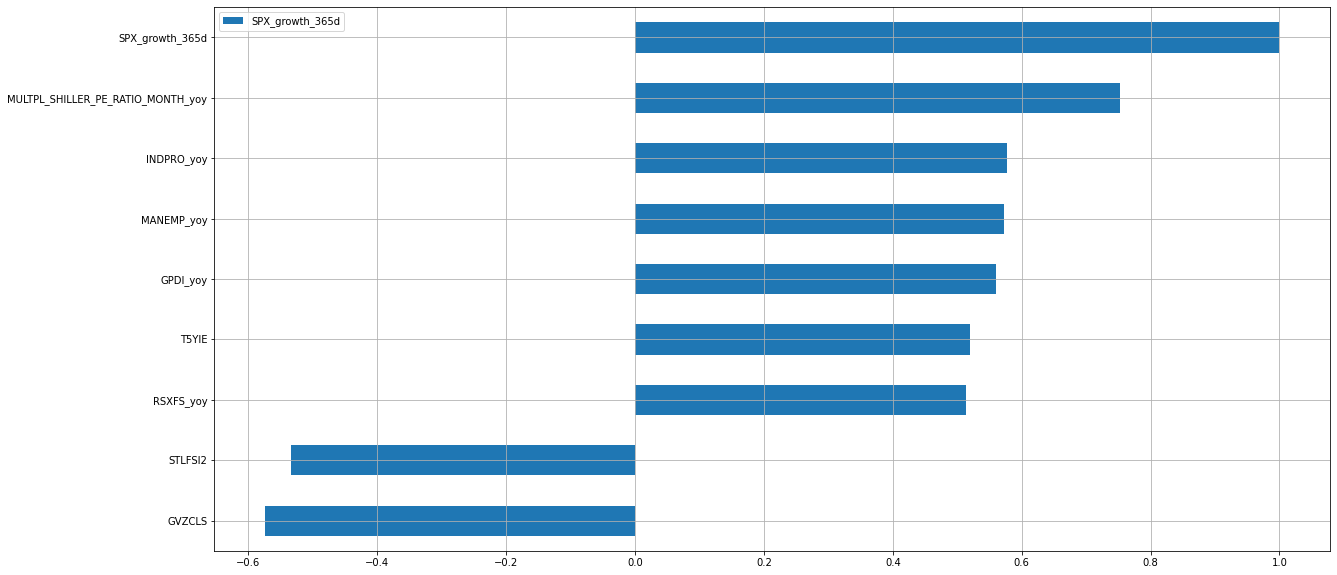

In [ ]:
filter = np.abs(SPX_growth_365d_corr.SPX_growth_365d)>=0.5
SPX_growth_365d_corr[filter].plot.barh(figsize=(20,10), grid=True)

In [ ]:
SPX_growth_90d=macro_df.corr()['SPX_growth_90d'].sort_values().to_frame()
SPX_growth_90d.head(10)

SPX_growth_90d
STLFSI2         -0.599893
GVZCLS          -0.531616
VIXCLS          -0.527476
TEDRATE         -0.314115
WALCL_mom       -0.311552
M1V             -0.257904
div_ratio       -0.234035
FODSP           -0.216783
CDSP            -0.202753
WALCL_wow       -0.183014

In [ ]:
SPX_growth_90d.tail(10)

SPX_growth_90d
RSXFS_yoy                                0.263038
SPX_growth_7d                            0.264906
SPCS20RSA_mom                            0.321423
T10YIE                                   0.379297
T5YIE                                    0.401805
SPX_growth_365d                          0.477265
MULTPL_SHILLER_PE_RATIO_MONTH_yoy        0.483739
MULTPL_SHILLER_PE_RATIO_MONTH_mom        0.541104
SPX_growth_30d                           0.547519
SPX_growth_90d                           1.000000

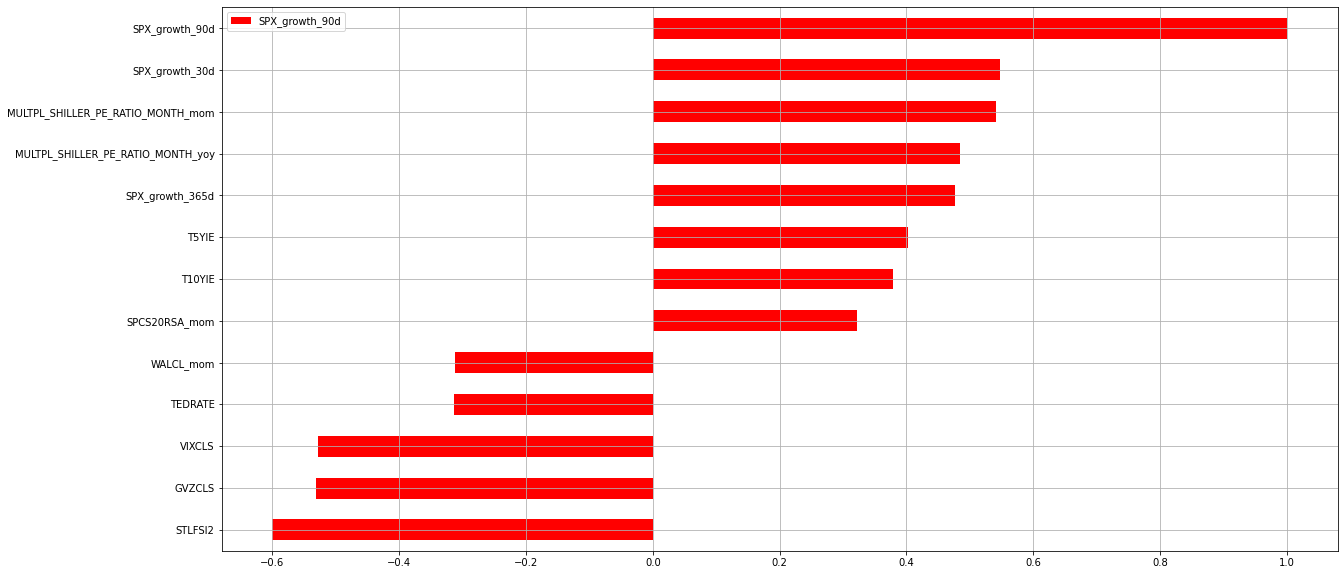

In [ ]:
SPX_growth_90d_corr = pd.DataFrame(macro_df.corr()['SPX_growth_90d'].sort_values())
filter = np.abs(SPX_growth_90d_corr.SPX_growth_90d)>=0.3
SPX_growth_90d_corr[filter].plot.barh(figsize=(20,10), grid=True,color='red')

In [ ]:
SPX_growth_30d=macro_df.corr()['SPX_growth_30d'].sort_values().to_frame()
SPX_growth_30d.head(10)

SPX_growth_30d
VIXCLS           -0.447530
STLFSI2          -0.419908
GVZCLS           -0.402826
WALCL_mom        -0.307998
WALCL_wow        -0.255933
TEDRATE          -0.228685
IC4WSA_wow       -0.199866
ICSA_mom         -0.153481
M1V              -0.146486
ICSA_wow         -0.143944

In [ ]:
SPX_growth_30d.tail(10)

SPX_growth_30d
PSAVERT                                  0.155427
T10YIE                                   0.156894
SPX_growth_1d                            0.172692
T5YIE                                    0.195297
SPX_growth_365d                          0.286226
SPX_growth_3d                            0.297572
SPX_growth_7d                            0.448377
MULTPL_SHILLER_PE_RATIO_MONTH_mom        0.452519
SPX_growth_90d                           0.547519
SPX_growth_30d                           1.000000

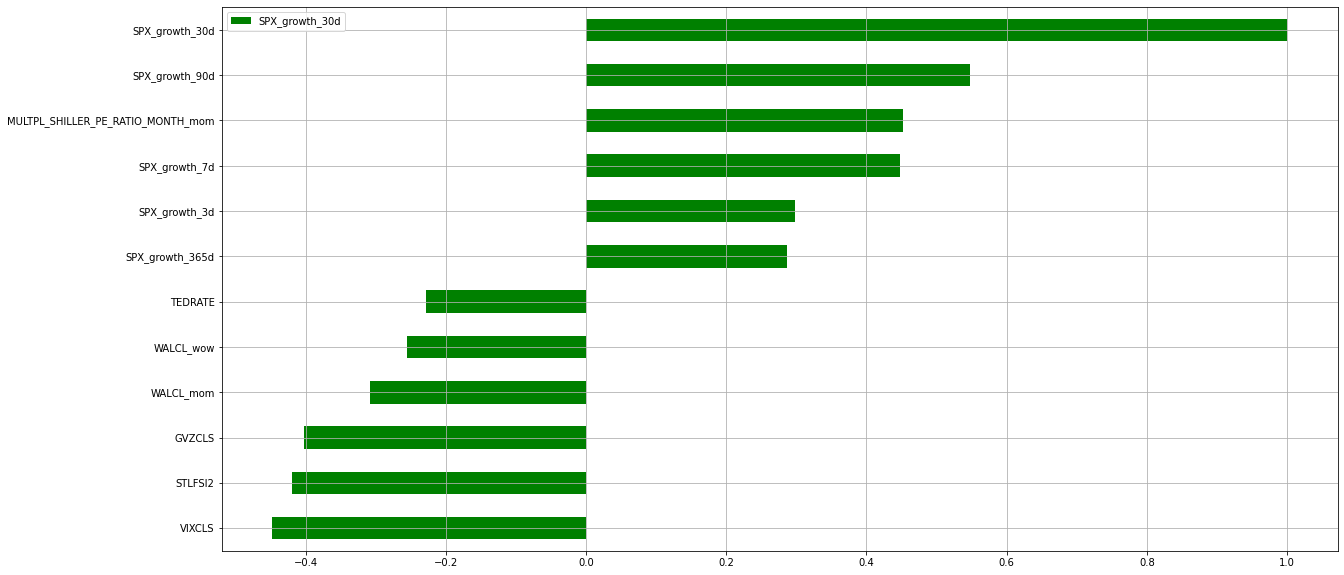

In [ ]:
SPX_growth_30d_corr = pd.DataFrame(macro_df.corr()['SPX_growth_30d'].sort_values())
filter = np.abs(SPX_growth_30d_corr.SPX_growth_30d)>=0.2
SPX_growth_30d_corr[filter].plot.barh(figsize=(20,10), grid=True,color='green')

# **b. Correlations between future changes of S&P index and current changes of economic indicators**

In [ ]:
# Future growth indicators are mostly correlated with each other
future_ind = []
for ind in macro_df.keys():
  if 'future' in ind:
    future_ind.append(ind)
  
print(future_ind)

['SPX_future_growth_1d', 'SPX_future_growth_3d', 'SPX_future_growth_7d', 'SPX_future_growth_30d', 'SPX_future_growth_90d', 'SPX_future_growth_365d']


In [ ]:
# include all features 
macro_df_no_future_ind = macro_df.keys()
# do not use future_ind in the list to find correlations with the label (which is a future_indicator)
macro_df_no_future_ind = macro_df_no_future_ind.drop(future_ind)

In [ ]:
SPX_future_growth_365d_corr = pd.DataFrame(macro_df.corr()['SPX_future_growth_365d'][macro_df_no_future_ind].sort_values())
SPX_future_growth_365d_corr.head(10)

SPX_future_growth_365d
T10YIE                                      -0.453803
T5YIE                                       -0.444611
M1V                                         -0.437230
T5YIFR                                      -0.356611
DCOILWTICO_growth_365d                      -0.323640
FODSP                                       -0.315215
MDSP                                        -0.286117
MULTPL_SHILLER_PE_RATIO_MONTH               -0.285736
MDSP_yoy                                    -0.280533
CDSP                                        -0.278985

In [ ]:
SPX_future_growth_365d_corr.tail(10)

SPX_future_growth_365d
HOUST_yoy                      0.217954
SPCS20RSA                      0.222318
UNRATE                         0.229368
GFDEGDQ188S_yoy                0.232042
GFDEGDQ188S                    0.235067
GFDEBTN_yoy                    0.235751
GVZCLS                         0.243435
DTWEXAFEGS                     0.315249
PSAVERT                        0.373913
DTWEXBGS                       0.380141

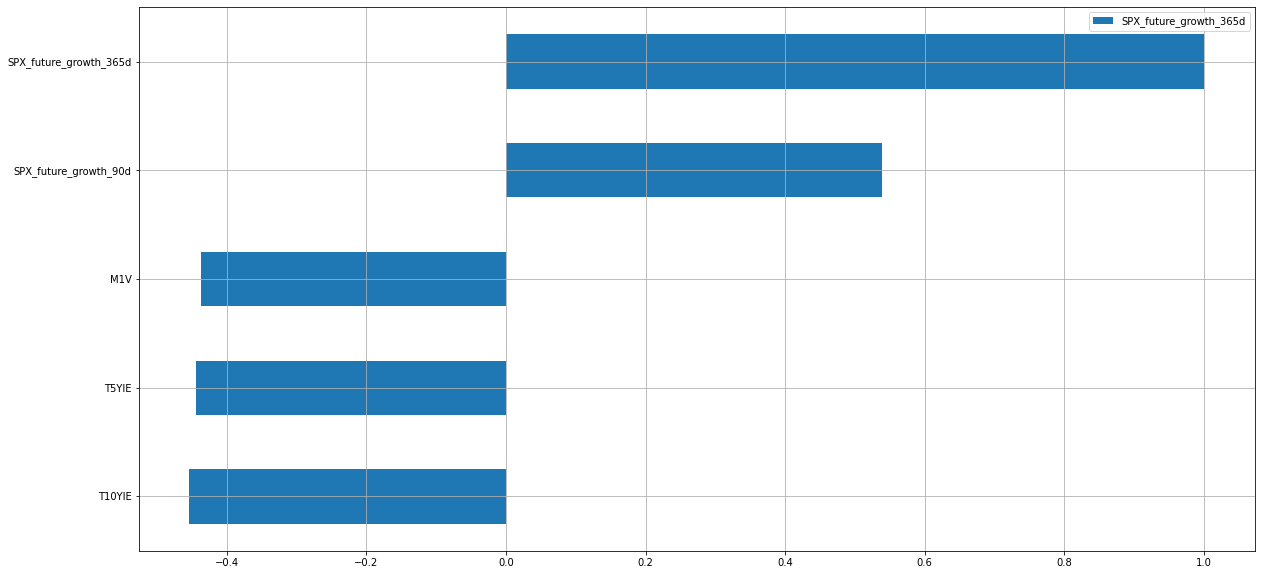

In [ ]:
SPX_future_365d_corr = pd.DataFrame(macro_df.corr()['SPX_future_growth_365d'].sort_values())
filter = np.abs(SPX_future_365d_corr.SPX_future_growth_365d)>=0.4
SPX_future_365d_corr[filter].plot.barh(figsize=(20,10), grid=True)

In [ ]:
SPX_future_growth_90d_corr = pd.DataFrame(macro_df.corr()['SPX_future_growth_90d'][macro_df_no_future_ind].sort_values())
SPX_future_growth_90d_corr.head(10)

SPX_future_growth_90d
M1V                                 -0.249844
T10YIE                              -0.236198
T5YIFR                              -0.235291
FODSP                               -0.204534
T5YIE                               -0.197065
CDSP                                -0.186799
DCOILWTICO_growth_365d              -0.183709
MDSP                                -0.174537
CPIAUCSL_yoy                        -0.167558
FODSP_yoy                           -0.165585

In [ ]:
SPX_future_growth_90d_corr.tail(10)

SPX_future_growth_90d
M1SL_yoy                      0.157681
SPCS20RSA_yoy                 0.162587
GFDEGDQ188S                   0.164645
GFDEGDQ188S_yoy               0.192077
SPCS20RSA_mom                 0.192503
DTWEXAFEGS                    0.201136
SPCS20RSA                     0.205648
GFDEBTN_yoy                   0.205723
PSAVERT                       0.224257
DTWEXBGS                      0.252069

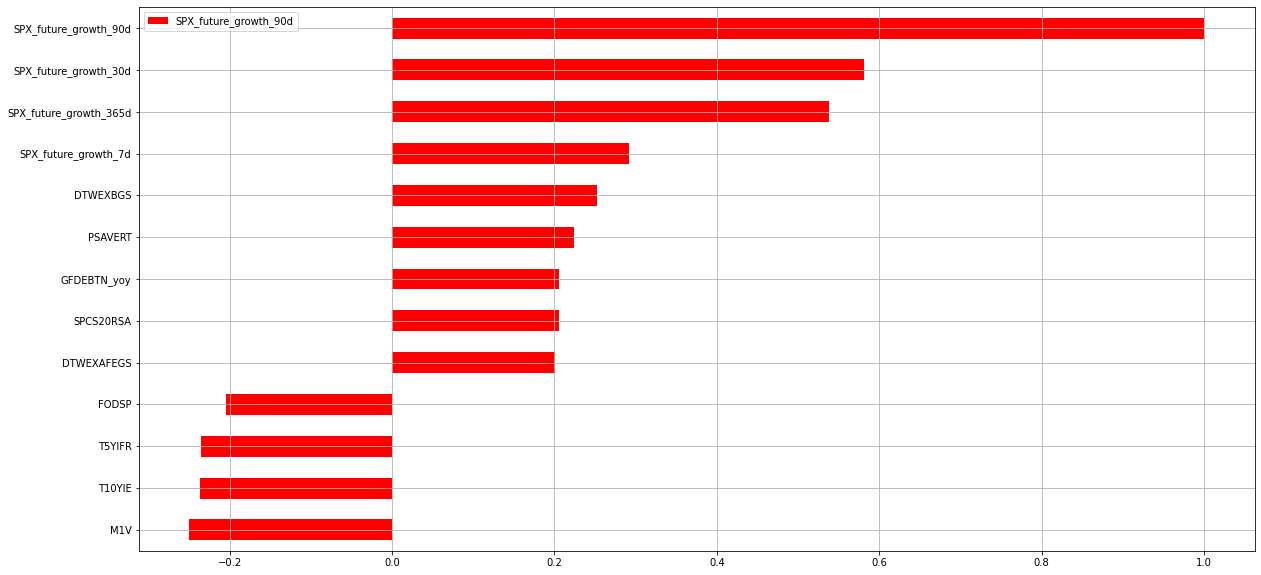

In [ ]:
SPX_future_90d_corr = pd.DataFrame(macro_df.corr()['SPX_future_growth_90d'].sort_values())
filter = np.abs(SPX_future_90d_corr.SPX_future_growth_90d)>=0.2
SPX_future_90d_corr[filter].plot.barh(figsize=(20,10), grid=True, color='red')

In [ ]:
SPX_future_growth_30d_corr = pd.DataFrame(macro_df.corr()['SPX_future_growth_30d'][macro_df_no_future_ind].sort_values())
SPX_future_growth_30d_corr.head(10)

SPX_future_growth_30d
M1V                       -0.142143
FODSP                     -0.113930
CDSP                      -0.104167
CPIAUCSL_yoy              -0.103243
MDSP                      -0.099410
T5YIFR                    -0.093743
EMRATIO                   -0.092217
T10YIE                    -0.086645
M1V_yoy                   -0.085299
PCE_yoy                   -0.081644

In [ ]:
SPX_future_growth_30d_corr.tail(10)

SPX_future_growth_30d
WM2NS_mom                     0.101933
GFDEGDQ188S_yoy               0.103298
SPCS20RSA_yoy                 0.105250
DTWEXAFEGS                    0.108068
VIXCLS                        0.109443
GFDEBTN_yoy                   0.116379
SPCS20RSA                     0.122580
SPCS20RSA_mom                 0.123496
DTWEXBGS                      0.144749
PSAVERT                       0.146107

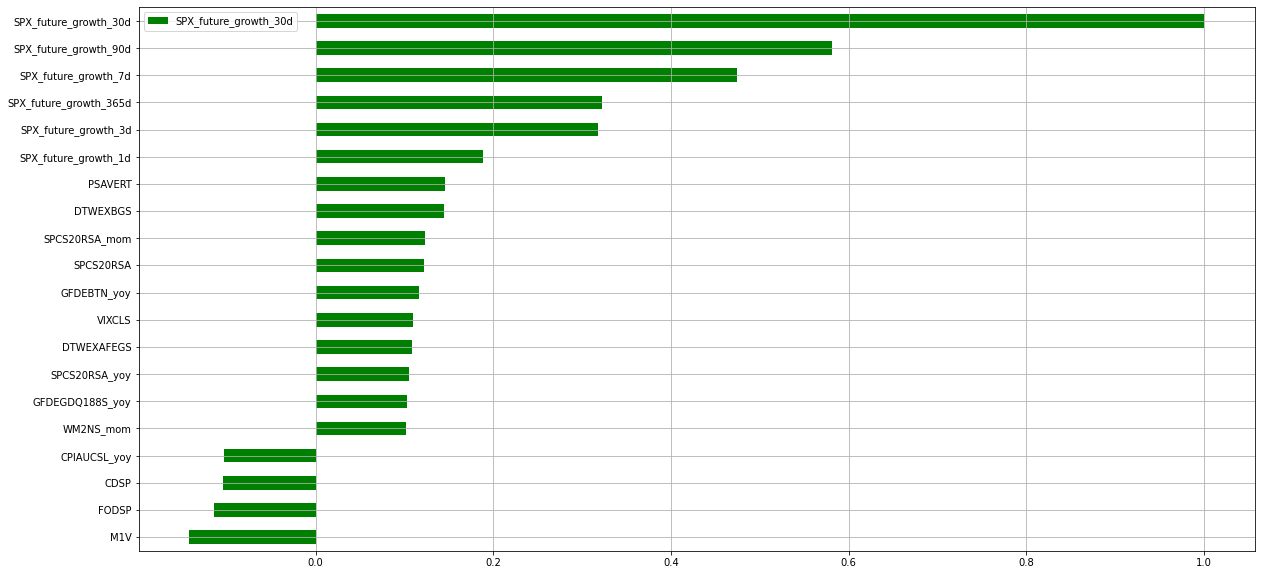

In [ ]:
SPX_future_30d_corr = pd.DataFrame(macro_df.corr()['SPX_future_growth_30d'].sort_values())
filter = np.abs(SPX_future_30d_corr.SPX_future_growth_30d)>=0.1
SPX_future_30d_corr[filter].plot.barh(figsize=(20,10), grid=True, color='green')

In [ ]:
macro_df.corr()['SPX_future_growth_365d'][macro_df_no_future_ind].sort_values()

T10YIE                   -0.453803
T5YIE                    -0.444611
M1V                      -0.437230
T5YIFR                   -0.356611
DCOILWTICO_growth_365d   -0.323640
                            ...   
GFDEBTN_yoy               0.235751
GVZCLS                    0.243435
DTWEXAFEGS                0.315249
PSAVERT                   0.373913
DTWEXBGS                  0.380141
Name: SPX_future_growth_365d, Length: 140, dtype: float64

In [ ]:
macro_df.corr()['SPX_future_growth_90d'][macro_df_no_future_ind].sort_values()

M1V           -0.249844
T10YIE        -0.236198
T5YIFR        -0.235291
FODSP         -0.204534
T5YIE         -0.197065
                 ...   
DTWEXAFEGS     0.201136
SPCS20RSA      0.205648
GFDEBTN_yoy    0.205723
PSAVERT        0.224257
DTWEXBGS       0.252069
Name: SPX_future_growth_90d, Length: 140, dtype: float64

In [ ]:
macro_df.corr()['SPX_future_growth_30d'][macro_df_no_future_ind].sort_values()

M1V             -0.142143
FODSP           -0.113930
CDSP            -0.104167
CPIAUCSL_yoy    -0.103243
MDSP            -0.099410
                   ...   
GFDEBTN_yoy      0.116379
SPCS20RSA        0.122580
SPCS20RSA_mom    0.123496
DTWEXBGS         0.144749
PSAVERT          0.146107
Name: SPX_future_growth_30d, Length: 140, dtype: float64

# **c. Decision Tree for Features Importance**

In [ ]:
# all features should be numeric
for key in macro_df.keys():
  macro_df[key] = macro_df[key].astype(float)

In [ ]:
# include all features 
X_keys = macro_df.keys()
# do not use future ind to predict
X_keys = X_keys.drop(future_ind)

In [ ]:
# deep copy of the dataframe not to change the original df
macro_copy = macro_df.copy(deep=True)

In [ ]:
# replace bad values with np.nan
macro_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
macro_copy.fillna(0,inplace=True)

In [ ]:
macro_copy.shape

(8821, 146)

In [ ]:
X = macro_copy[X_keys]
#get all features in X and dependent variable in y
y = macro_copy['SPX_future_growth_90d']
print(X.shape)
print(y.shape)

(8821, 140)
(8821,)


In [ ]:
# define a function that returns an ordered dictionary of features, sorted by importance
def get_importance_features(model):
  importance = model.feature_importances_
  feat_imp = OrderedDict()
  # summarize feature importance
  for i,v in enumerate(importance):
    feat_imp[X.keys()[i]] = importance[i]

  # https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value  
  sorted_feat_imp = sorted(feat_imp.items(), key=lambda kv: kv[1])

  return sorted_feat_imp

In [ ]:
# init the class and fit the model
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X, y)

decision_feat_imp = get_importance_features(decision_tree_model)


In [ ]:
# Prediction of SPX_future_growth_90d:
decision_feat_imp[-10:]

[('GFDEGDQ188S', 0.03148558452098283),
 ('SPX', 0.03510741283278939),
 ('TCU', 0.0374912531306394),
 ('CP_qoq', 0.04299886445007408),
 ('CIVPART_yoy', 0.04607285802250115),
 ('NROU', 0.05471129749390034),
 ('CP_yoy', 0.06724459433278768),
 ('VIXCLS', 0.07486213654372309),
 ('div_ratio', 0.08461692473003996),
 ('M1V', 0.13774407678058118)]

# **d. Multicollinearity (VIF test):**

In [ ]:
df=macro_df.copy()
#df.reset_index(inplace=True)
df.tail()

WM1NS_wow  WM1NS_mom  WM2NS_wow  WM2NS_mom  WALCL_wow  WALCL_mom  \
2021-12-27   0.001546   0.018919   0.002143   0.018602   0.003863   0.013317   
2021-12-28   0.001546   0.018919   0.002143   0.018602   0.003863   0.013317   
2021-12-29   0.001546   0.018919   0.002143   0.018602  -0.003758   0.008718   
2021-12-30   0.001546   0.018919   0.002143   0.018602  -0.003758   0.008718   
2021-12-31   0.001546   0.018919   0.002143   0.018602  -0.003758   0.008718   

             DFF  DTB3  DGS5  DGS10  ...  GFDEGDQ188S_qoq  GFDEGDQ188S_yoy  \
2021-12-27  0.08  0.06  1.26   1.48  ...        -0.023339        -0.038787   
2021-12-28  0.08  0.06  1.27   1.49  ...        -0.023339        -0.038787   
2021-12-29  0.08  0.05  1.29   1.55  ...        -0.023339        -0.038787   
2021-12-30  0.08  0.05  1.27   1.52  ...        -0.023339        -0.038787   
2021-12-31  0.07  0.06  1.26   1.52  ...        -0.023339        -0.038787   

            DIVIDEND_qoq  DIVIDEND_yoy   SPCS20RSA  SPCS20RSA_mom  \
2021-12-27      0.019618      0.051214  282.838197       0.012423   
2021-12-28      0.019618      0.051214  282.838197       0.012423   
2021-12-29      0.019618      0.051214  282.838197       0.012423   
2021-12-30      0.019618      0.051214  282.838197       0.012423   
2021-12-31      0.019618      0.051214  282.838197       0.012423   

            SPCS20RSA_yoy  MULTPL_SHILLER_PE_RATIO_MONTH  \
2021-12-27       0.182612                          38.54   
2021-12-28       0.182612                          38.54   
2021-12-29       0.182612                          38.54   
2021-12-30       0.182612                          38.54   
2021-12-31       0.182612                          38.31   

            MULTPL_SHILLER_PE_RATIO_MONTH_mom  \
2021-12-27                          -0.001037   
2021-12-28                          -0.001037   
2021-12-29                          -0.001037   
2021-12-30                          -0.001037   
2021-12-31                          -0.005968   

            MULTPL_SHILLER_PE_RATIO_MONTH_yoy  
2021-12-27                           0.049564  
2021-12-28                           0.049564  
2021-12-29                           0.049564  
2021-12-30                           0.049564  
2021-12-31                           0.019968  

[5 rows x 146 columns]

In [ ]:
features = macro_copy[['DTWEXAFEGS', 
'SPCS20RSA',
'GFDEBTN_yoy',
'PSAVERT',
'M1V',
'T10YIE',
'T5YIFR',
'FODSP',
'T5YIE']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                          for i in range(len(features.columns))]
  
print(vif_data)

       feature           VIF
0   DTWEXAFEGS  8.055343e+00
1    SPCS20RSA  1.306786e+01
2  GFDEBTN_yoy  4.879780e+00
3      PSAVERT  1.462149e+01
4          M1V  6.512817e+01
5       T10YIE  3.049968e+06
6       T5YIFR  8.952578e+05
7        FODSP  1.120458e+02
8        T5YIE  6.607613e+05


In [ ]:
features = macro_copy[['DTWEXAFEGS', 
'SPCS20RSA',
'GFDEBTN_yoy',
'PSAVERT',
'M1V',
'T5YIFR']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                          for i in range(len(features.columns))]
  
print(vif_data)

       feature        VIF
0   DTWEXAFEGS   6.504048
1    SPCS20RSA  10.696001
2  GFDEBTN_yoy   4.811442
3      PSAVERT   6.100559
4          M1V   4.585943
5       T5YIFR  10.537090


In [ ]:
features = macro_copy[['DTWEXAFEGS', 
'SPCS20RSA',
'GFDEBTN_yoy',
'PSAVERT',
'M1V',
'T5YIFR','CIVPART_yoy','CP_yoy','VIXCLS']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                          for i in range(len(features.columns))]
  
print(vif_data)

       feature        VIF
0   DTWEXAFEGS   8.363389
1    SPCS20RSA  12.052714
2  GFDEBTN_yoy   5.432160
3      PSAVERT   6.641401
4          M1V   8.961544
5       T5YIFR  13.749673
6  CIVPART_yoy   1.568466
7       CP_yoy   1.726241
8       VIXCLS   6.798297


# **Section 7: Modelling and metrics**

# **a.Decision Tree Model**

In [ ]:
X=macro_copy[['DTWEXAFEGS', 
'SPCS20RSA',
'GFDEBTN_yoy',
'PSAVERT',
'M1V',
'T5YIFR','CIVPART_yoy','CP_yoy','VIXCLS']]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [ ]:
# define the model
decision_tree_model2 = DecisionTreeRegressor()
decision_tree_model2.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
y_pred = decision_tree_model2.predict(X_test)

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df[0:10]

Actual  Predicted
2018-07-02  0.034501   0.008679
2018-07-03  0.016224   0.006357
2018-07-05 -0.012175  -0.001962
2018-07-06 -0.022265  -0.001962
2018-07-09 -0.033023  -0.020640
2018-07-10 -0.015797  -0.020640
2018-07-11 -0.022164  -0.001962
2018-07-12 -0.039474  -0.020640
2018-07-13 -0.055939  -0.014020
2018-07-16 -0.056813  -0.020640

Text(0.5, 1.0, 'Graph No.4- Decision Tree Actural-Predicted on test set')

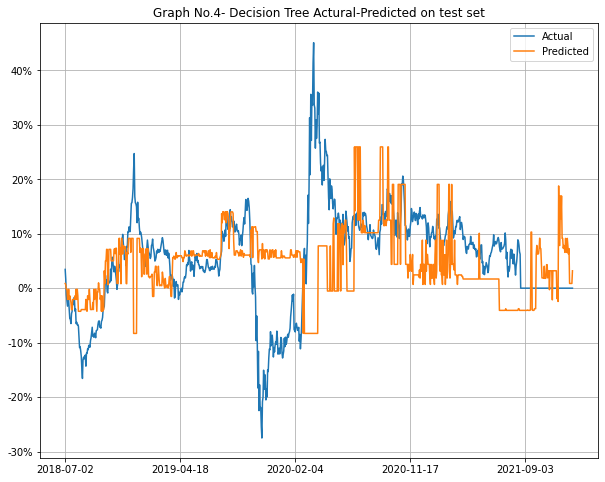

In [ ]:
# Decision Tree : Actual vs. Predicted graph
import matplotlib.ticker as mtick

ax = df.plot(figsize=(10,8), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_title('Graph No.4- Decision Tree Actural-Predicted on test set')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Graph No.5-The distribution of Decision Tree errors')

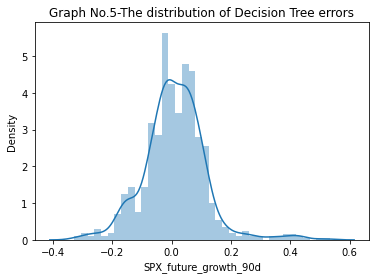

In [ ]:
# what is the distribution of errors?
import seaborn as sns
sns.distplot(y_test-y_pred)
plt.title('Graph No.5-The distribution of Decision Tree errors')

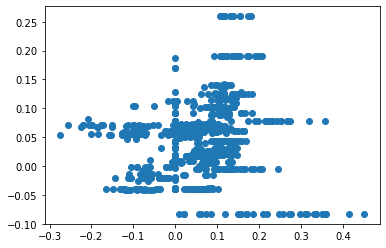

In [ ]:
plt.scatter(y_test,y_pred)

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.07701573891750466
Mean Squared Error: 0.01128466492016972
Root Mean Squared Error: 0.10622930349093757


# **b. Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(max_depth=8, random_state=0)

In [ ]:
clf.fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)
df2 = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred_clf})
df2.head()

Actual  Predicted
2018-07-02  0.034501   0.039809
2018-07-03  0.016224   0.039809
2018-07-05 -0.012175   0.039809
2018-07-06 -0.022265   0.039845
2018-07-09 -0.033023   0.039845

Text(0.5, 1.0, 'Graph No.5- Random Forest Actural-Predicted on test set')

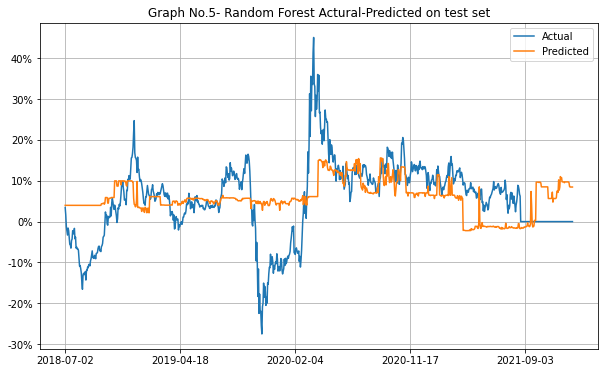

In [ ]:
# Random Forest regressor : Actual vs. Predicted graph

import matplotlib.ticker as mtick

ax = df2.plot(figsize=(10,6), grid=True)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_title('Graph No.5- Random Forest Actural-Predicted on test set')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


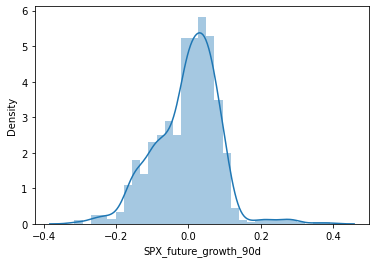

In [ ]:

# what is the distribution of errors?
import seaborn as sns
sns.distplot(y_test-y_pred_clf)

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_clf))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_clf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_clf)))

Mean Absolute Error: 0.06699877231873316
Mean Squared Error: 0.007715883428461824
Root Mean Squared Error: 0.08784010148253373


# **c. Linear Regression**


In [ ]:
df_final= macro_copy[['SPX_future_growth_90d',
'DTWEXAFEGS', 
'SPCS20RSA',
'GFDEBTN_yoy',
'PSAVERT',
'M1V',
'T5YIFR','CIVPART_yoy','CP_yoy','VIXCLS']]

In [ ]:
df_final.head()

SPX_future_growth_90d  DTWEXAFEGS  SPCS20RSA  GFDEBTN_yoy  \
1987-01-05               0.164016         0.0        0.0          0.0   
1987-01-06               0.125720         0.0        0.0          0.0   
1987-01-07               0.114156         0.0        0.0          0.0   
1987-01-08               0.080741         0.0        0.0          0.0   
1987-01-09               0.068805         0.0        0.0          0.0   

            PSAVERT    M1V  T5YIFR  CIVPART_yoy  CP_yoy  VIXCLS  
1987-01-05      9.7  6.455     0.0          0.0     0.0     0.0  
1987-01-06      9.7  6.455     0.0          0.0     0.0     0.0  
1987-01-07      9.7  6.455     0.0          0.0     0.0     0.0  
1987-01-08      9.7  6.455     0.0          0.0     0.0     0.0  
1987-01-09      9.7  6.455     0.0          0.0     0.0     0.0

In [ ]:
from sklearn.model_selection import train_test_split
features = df_final.drop(columns = ['SPX_future_growth_90d'], axis = 1)
labels = df_final[['SPX_future_growth_90d']]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.1, random_state = 0)

In [ ]:
print(f"Shape of training data: {X_train.shape}")
print(f"Shape of the training target data: {y_train.shape}")

print(f"Shape of test data: {X_test.shape}")
print(f"Shape of the test target data: {y_test.shape}")

Shape of training data: (7938, 9)
Shape of the training target data: (7938, 1)
Shape of test data: (883, 9)
Shape of the test target data: (883, 1)


In [ ]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
  
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.16321827804147593


In [ ]:
X=macro_copy[[
'DTWEXAFEGS', 
'SPCS20RSA',
'GFDEBTN_yoy',
'PSAVERT',
'M1V',
'T5YIFR','CIVPART_yoy','CP_yoy','VIXCLS']]

In [ ]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)
coefficients

0         0
0   DTWEXAFEGS -0.000125
1    SPCS20RSA -0.000480
2  GFDEBTN_yoy  0.109287
3      PSAVERT  0.002515
4          M1V -0.014859
5       T5YIFR  0.033993
6  CIVPART_yoy  1.038960
7       CP_yoy  0.030304
8       VIXCLS  0.002792

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_pred = regr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

r2 = r2_score(y_test, y_pred)
print('r2 score for Linear Regression model is', r2)

MSE:  0.00702768417729609
RMSE:  0.003513842088648045
r2 score for Linear Regression model is 0.16321827804147593


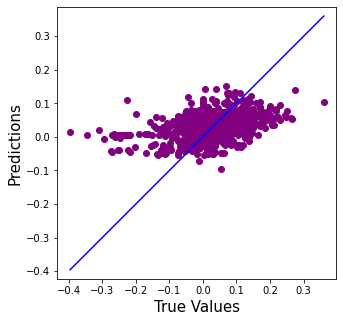

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(y_test['SPX_future_growth_90d'].values, y_pred, c='purple')


p1 = max(max(y_pred), max(y_test['SPX_future_growth_90d'].values))
p2 = min(min(y_pred), min(y_test['SPX_future_growth_90d'].values))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
import statsmodels.formula.api as smf

train=df_final.iloc[0:7000,]
test=df_final.iloc[7000:,]
formula = 'SPX_future_growth_90d ~ ' + '+'.join(df_final[[
'DTWEXAFEGS', 
'SPCS20RSA',
'GFDEBTN_yoy',
'PSAVERT',
'M1V',
'T5YIFR','CIVPART_yoy','CP_yoy','VIXCLS']])
smf_model = smf.ols(formula=formula, data=train)
results_full = smf_model.fit()
print (results_full.summary())

                              OLS Regression Results                             
Dep. Variable:     SPX_future_growth_90d   R-squared:                       0.193
Model:                               OLS   Adj. R-squared:                  0.192
Method:                    Least Squares   F-statistic:                     185.7
Date:                   Fri, 24 Jun 2022   Prob (F-statistic):          2.31e-317
Time:                           19:54:17   Log-Likelihood:                 7404.8
No. Observations:                   7000   AIC:                        -1.479e+04
Df Residuals:                       6990   BIC:                        -1.472e+04
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.29

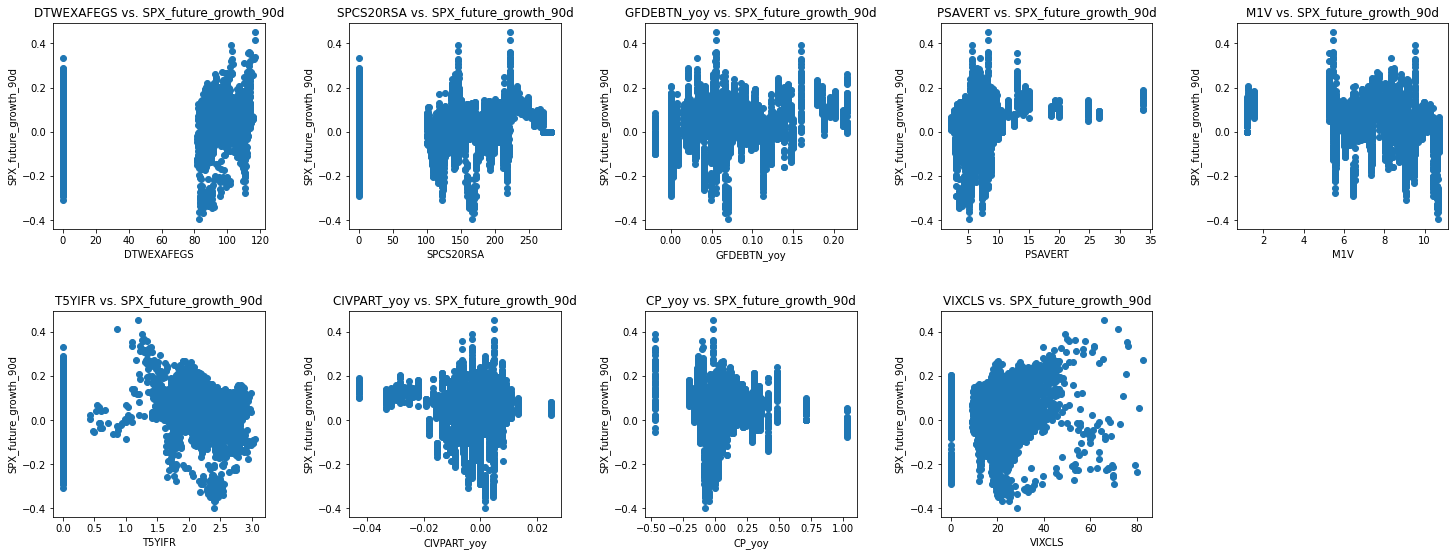

In [ ]:
fig = plt.figure(figsize=(25, 25))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,10):
    ax = fig.add_subplot(5, 5, i)
    ax.scatter((df_final[df_final.columns[i]]),(df_final[df_final.columns[0]]))
    ax.set(xlabel=df_final.columns[i], ylabel='SPX_future_growth_90d',
       title= df_final.columns[i]+' vs. SPX_future_growth_90d')

# **d. Prophet**


In [ ]:
!pip  install prophet 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.7 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6642464 sha256=06edfa0981a91879b9f8843b2a80c0551de993c4ed89fc30d2c6eea151465c4d
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from prophet import Prophet
from matplotlib import pyplot as plt
import seaborn as sn 
import pandas as pd

In [ ]:
train=macro_copy.iloc[0:7000,]
train=train.reset_index()
train['index']=pd.to_datetime(train['index'])
train=train[['index','SPX_future_growth_90d',
'DTWEXAFEGS', 
'SPCS20RSA',
'GFDEBTN_yoy',
'PSAVERT',
'M1V',
'T5YIFR','CIVPART_yoy','CP_yoy','VIXCLS']]


train.head()


index  SPX_future_growth_90d  DTWEXAFEGS  SPCS20RSA  GFDEBTN_yoy  \
0 1987-01-05               0.164016         0.0        0.0          0.0   
1 1987-01-06               0.125720         0.0        0.0          0.0   
2 1987-01-07               0.114156         0.0        0.0          0.0   
3 1987-01-08               0.080741         0.0        0.0          0.0   
4 1987-01-09               0.068805         0.0        0.0          0.0   

   PSAVERT    M1V  T5YIFR  CIVPART_yoy  CP_yoy  VIXCLS  
0      9.7  6.455     0.0          0.0     0.0     0.0  
1      9.7  6.455     0.0          0.0     0.0     0.0  
2      9.7  6.455     0.0          0.0     0.0     0.0  
3      9.7  6.455     0.0          0.0     0.0     0.0  
4      9.7  6.455     0.0          0.0     0.0     0.0

In [ ]:
test=macro_copy.iloc[7000:,]
test=test.reset_index()
test['index']=pd.to_datetime(test['index'])
test=test[['index','SPX_future_growth_90d',
'DTWEXAFEGS', 
'SPCS20RSA',
'GFDEBTN_yoy',
'PSAVERT',
'M1V',
'T5YIFR','CIVPART_yoy','CP_yoy','VIXCLS']]



test.head()


index  SPX_future_growth_90d  DTWEXAFEGS  SPCS20RSA  GFDEBTN_yoy  \
0 2014-10-09               0.107112     96.0879  171.47857     0.064875   
1 2014-10-10               0.125308     96.3376  171.47857     0.064875   
2 2014-10-13               0.126634      0.0000  171.47857     0.064875   
3 2014-10-14               0.134964     96.4121  171.47857     0.064875   
4 2014-10-15               0.133125     96.0061  171.47857     0.064875   

   PSAVERT    M1V  T5YIFR  CIVPART_yoy    CP_yoy  VIXCLS  
0      7.2  6.253    2.42    -0.006329  0.069732   18.76  
1      7.2  6.253    2.40    -0.006329  0.069732   21.24  
2      7.2  6.253    0.00    -0.006329  0.069732   24.64  
3      7.2  6.253    2.43    -0.006329  0.069732   22.79  
4      7.2  6.253    2.35    -0.006329  0.069732   26.25

In [ ]:
train.rename(columns={'SPX_future_growth_90d':'y','index':'ds'},inplace=True)
train.head()

ds         y  DTWEXAFEGS  SPCS20RSA  GFDEBTN_yoy  PSAVERT    M1V  \
0 1987-01-05  0.164016         0.0        0.0          0.0      9.7  6.455   
1 1987-01-06  0.125720         0.0        0.0          0.0      9.7  6.455   
2 1987-01-07  0.114156         0.0        0.0          0.0      9.7  6.455   
3 1987-01-08  0.080741         0.0        0.0          0.0      9.7  6.455   
4 1987-01-09  0.068805         0.0        0.0          0.0      9.7  6.455   

   T5YIFR  CIVPART_yoy  CP_yoy  VIXCLS  
0     0.0          0.0     0.0     0.0  
1     0.0          0.0     0.0     0.0  
2     0.0          0.0     0.0     0.0  
3     0.0          0.0     0.0     0.0  
4     0.0          0.0     0.0     0.0

In [ ]:
cols=[
'DTWEXAFEGS', 
'SPCS20RSA',
'GFDEBTN_yoy',
'PSAVERT',
'M1V',
'T5YIFR','CIVPART_yoy','CP_yoy','VIXCLS']


In [ ]:
model= Prophet()

for col in cols:

    model.add_regressor(col,standardize=False)
    
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
model.params

{'beta': array([[-2.19435429e-02,  5.01186029e-02,  6.05474967e-03,
         -1.20302299e-02, -6.41771293e-03, -1.12099110e-03,
         -3.21785792e-04, -2.99709519e-04, -2.51026920e-03,
          2.55655558e-04, -1.27761918e-03,  1.58189903e-03,
          3.81370849e-03, -7.17838798e-03,  2.71441009e-03,
          2.89944081e-03, -5.53731655e-03, -4.27630842e-03,
         -7.34889160e-03, -4.20247603e-03, -2.09258787e-01,
          1.67913178e-01,  1.81763274e-01,  4.17586069e-02,
         -2.88710856e-02, -6.02906091e-02,  2.16046422e-03,
          1.65899010e-04,  1.70664562e+00, -2.31152965e-03,
         -1.93822158e-01,  7.92957381e-02,  6.66173381e-01,
         -1.79668420e-02,  6.75530362e-03]]),
 'delta': array([[ 2.00682796e-03, -3.38950446e-01, -2.82046241e-02,
         -2.46753160e-04,  6.96625021e-02,  8.05701446e-01,
          1.30256053e+00,  1.38531876e+00,  4.11571681e-01,
          5.70158432e-05, -4.54306438e-01, -1.09030048e+00,
         -1.19022574e+00, -8.87610685

In [ ]:
test.rename(columns={'SPX_future_growth_90d':'y','index':'ds'},inplace=True)
test.head()

ds         y  DTWEXAFEGS  SPCS20RSA  GFDEBTN_yoy  PSAVERT    M1V  \
0 2014-10-09  0.107112     96.0879  171.47857     0.064875      7.2  6.253   
1 2014-10-10  0.125308     96.3376  171.47857     0.064875      7.2  6.253   
2 2014-10-13  0.126634      0.0000  171.47857     0.064875      7.2  6.253   
3 2014-10-14  0.134964     96.4121  171.47857     0.064875      7.2  6.253   
4 2014-10-15  0.133125     96.0061  171.47857     0.064875      7.2  6.253   

   T5YIFR  CIVPART_yoy    CP_yoy  VIXCLS  
0    2.42    -0.006329  0.069732   18.76  
1    2.40    -0.006329  0.069732   21.24  
2    0.00    -0.006329  0.069732   24.64  
3    2.43    -0.006329  0.069732   22.79  
4    2.35    -0.006329  0.069732   26.25

In [ ]:
test2=test[['ds','DTWEXAFEGS', 
'SPCS20RSA',
'GFDEBTN_yoy',
'PSAVERT',
'M1V',
'T5YIFR','CIVPART_yoy','CP_yoy','VIXCLS']]
test2

ds  DTWEXAFEGS   SPCS20RSA  GFDEBTN_yoy  PSAVERT    M1V  T5YIFR  \
0    2014-10-09     96.0879  171.478570     0.064875      7.2  6.253    2.42   
1    2014-10-10     96.3376  171.478570     0.064875      7.2  6.253    2.40   
2    2014-10-13      0.0000  171.478570     0.064875      7.2  6.253    0.00   
3    2014-10-14     96.4121  171.478570     0.064875      7.2  6.253    2.43   
4    2014-10-15     96.0061  171.478570     0.064875      7.2  6.253    2.35   
...         ...         ...         ...          ...      ...    ...     ...   
1816 2021-12-27    108.0323  282.838197     0.055057      7.6  1.177    2.25   
1817 2021-12-28    108.1098  282.838197     0.055057      7.6  1.177    2.22   
1818 2021-12-29    107.9842  282.838197     0.055057      7.6  1.177    2.23   
1819 2021-12-30    107.9758  282.838197     0.055057      7.6  1.177    2.30   
1820 2021-12-31      0.0000  282.838197     0.055057      7.6  1.177    2.25   

      CIVPART_yoy    CP_yoy  VIXCLS  
0       -0.006329  0.069732   18.76  
1       -0.006329  0.069732   21.24  
2       -0.006329  0.069732   24.64  
3       -0.006329  0.069732   22.79  
4       -0.006329  0.069732   26.25  
...           ...       ...     ...  
1816     0.006504  0.266947   17.68  
1817     0.006504  0.266947   17.54  
1818     0.006504  0.266947   16.95  
1819     0.006504  0.266947   17.33  
1820     0.006504  0.266947   17.22  

[1821 rows x 10 columns]

In [ ]:
y_test=test[['y']]
y_test

y
0     0.107112
1     0.125308
2     0.126634
3     0.134964
4     0.133125
...        ...
1816  0.000000
1817  0.000000
1818  0.000000
1819  0.000000
1820  0.000000

[1821 rows x 1 columns]

In [ ]:
#forcast1=forcast1[['ds','yhat']]
forcast1=model.predict(test2)
forcast1.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-10-09  0.228381   -0.016027    0.178239     0.228381     0.228381   
1 2014-10-10  0.228307   -0.010623    0.191083     0.228307     0.228307   
2 2014-10-13  0.228086   -0.152230    0.035878     0.228086     0.228086   
3 2014-10-14  0.228013   -0.001763    0.181963     0.228013     0.228013   
4 2014-10-15  0.227939   -0.001869    0.196056     0.227939     0.227939   

   CIVPART_yoy  CIVPART_yoy_lower  CIVPART_yoy_upper    CP_yoy  ...    weekly  \
0    -0.001669          -0.001669          -0.001669 -0.000496  ...  0.059126   
1    -0.001669          -0.001669          -0.001669 -0.000496  ...  0.059685   
2    -0.001669          -0.001669          -0.001669 -0.000496  ...  0.059061   
3    -0.001669          -0.001669          -0.001669 -0.000496  ...  0.058471   
4    -0.001669          -0.001669          -0.001669 -0.000496  ...  0.058835   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0      0.059126      0.059126  0.020910      0.020910      0.020910   
1      0.059685      0.059685  0.020660      0.020660      0.020660   
2      0.059061      0.059061  0.019067      0.019067      0.019067   
3      0.058471      0.058471  0.018320      0.018320      0.018320   
4      0.058835      0.058835  0.017505      0.017505      0.017505   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper      yhat  
0                         0.0  0.083324  
1                         0.0  0.089777  
2                         0.0 -0.061277  
3                         0.0  0.091077  
4                         0.0  0.096946  

[5 rows x 49 columns]

In [ ]:
forcast1=forcast1[['ds','yhat']]
forcast1.head()

ds      yhat
0 2014-10-09  0.083324
1 2014-10-10  0.089777
2 2014-10-13 -0.061277
3 2014-10-14  0.091077
4 2014-10-15  0.096946

In [ ]:
df_final=pd.merge(forcast1,test , on = "ds", how = "right")

In [ ]:
df_final.head()

ds      yhat         y  DTWEXAFEGS  SPCS20RSA  GFDEBTN_yoy  PSAVERT  \
0 2014-10-09  0.083324  0.107112     96.0879  171.47857     0.064875      7.2   
1 2014-10-10  0.089777  0.125308     96.3376  171.47857     0.064875      7.2   
2 2014-10-13 -0.061277  0.126634      0.0000  171.47857     0.064875      7.2   
3 2014-10-14  0.091077  0.134964     96.4121  171.47857     0.064875      7.2   
4 2014-10-15  0.096946  0.133125     96.0061  171.47857     0.064875      7.2   

     M1V  T5YIFR  CIVPART_yoy    CP_yoy  VIXCLS  
0  6.253    2.42    -0.006329  0.069732   18.76  
1  6.253    2.40    -0.006329  0.069732   21.24  
2  6.253    0.00    -0.006329  0.069732   24.64  
3  6.253    2.43    -0.006329  0.069732   22.79  
4  6.253    2.35    -0.006329  0.069732   26.25

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(df_final['yhat'],df_final['y']))
rms

0.13906205075620545

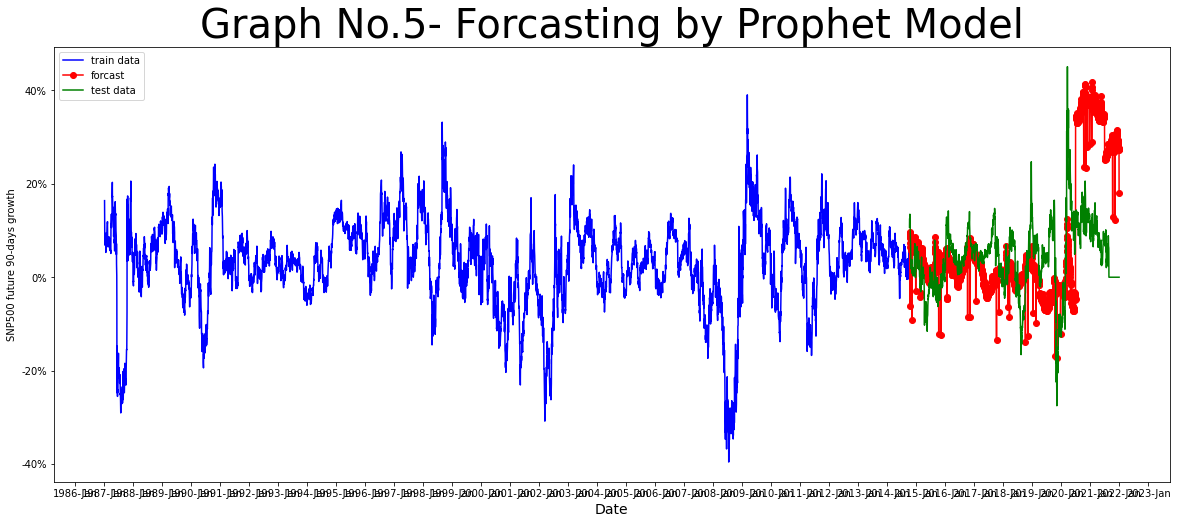

In [ ]:
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(20,8))
plt.plot(train['ds'],train['y'],label='train data',color='blue')
plt.plot(df_final['ds'],df_final['yhat'],color='red',label='forcast',marker = 'o')
plt.plot(df_final['ds'],df_final['y'],color='green',label='test data ')
plt.title('Graph No.5- Forcasting by Prophet Model', fontsize=40,color="black")
plt.xlabel('Date',fontsize=14)
plt.ylabel('SNP500 future 90-days growth',fontsize=10)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
#plt.xticks(color='white')
plt.legend()


In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(df_final['yhat'], df_final['y']))
print('Mean Squared Error:', metrics.mean_squared_error(df_final['yhat'], df_final['y']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_final['yhat'], df_final['y'])))

Mean Absolute Error: 0.1035522120830208
Mean Squared Error: 0.019338253960521464
Root Mean Squared Error: 0.13906205075620545


In [ ]:
df_final=df_final[['yhat','y']]
df_final.head()

yhat         y
0  0.083324  0.107112
1  0.089777  0.125308
2 -0.061277  0.126634
3  0.091077  0.134964
4  0.096946  0.133125

In [ ]:
(df_final['y']-df_final['yhat']).describe()

count    1821.000000
mean       -0.031205
std         0.135553
min        -0.333094
25%        -0.086199
50%        -0.002165
75%         0.055463
max         0.369124
dtype: float64

# **e. LSTM**

In [ ]:
train_data=macro_copy.iloc[0:7000,]
train=train_data[['DTWEXAFEGS', 
'SPCS20RSA',
'GFDEBTN_yoy',
'PSAVERT',
'M1V',
'T5YIFR','CIVPART_yoy','CP_yoy','VIXCLS']]
#train.reset_index()
train.head()

DTWEXAFEGS  SPCS20RSA  GFDEBTN_yoy  PSAVERT    M1V  T5YIFR  \
1987-01-05         0.0        0.0          0.0      9.7  6.455     0.0   
1987-01-06         0.0        0.0          0.0      9.7  6.455     0.0   
1987-01-07         0.0        0.0          0.0      9.7  6.455     0.0   
1987-01-08         0.0        0.0          0.0      9.7  6.455     0.0   
1987-01-09         0.0        0.0          0.0      9.7  6.455     0.0   

            CIVPART_yoy  CP_yoy  VIXCLS  
1987-01-05          0.0     0.0     0.0  
1987-01-06          0.0     0.0     0.0  
1987-01-07          0.0     0.0     0.0  
1987-01-08          0.0     0.0     0.0  
1987-01-09          0.0     0.0     0.0

In [ ]:
test_data = macro_copy.iloc[7000:,]
test=test_data[['DTWEXAFEGS', 
'SPCS20RSA',
'GFDEBTN_yoy',
'PSAVERT',
'M1V',
'T5YIFR','CIVPART_yoy','CP_yoy','VIXCLS']]
print(test.shape)
#test.reset_index()
test.head()

(1821, 9)


DTWEXAFEGS  SPCS20RSA  GFDEBTN_yoy  PSAVERT    M1V  T5YIFR  \
2014-10-09     96.0879  171.47857     0.064875      7.2  6.253    2.42   
2014-10-10     96.3376  171.47857     0.064875      7.2  6.253    2.40   
2014-10-13      0.0000  171.47857     0.064875      7.2  6.253    0.00   
2014-10-14     96.4121  171.47857     0.064875      7.2  6.253    2.43   
2014-10-15     96.0061  171.47857     0.064875      7.2  6.253    2.35   

            CIVPART_yoy    CP_yoy  VIXCLS  
2014-10-09    -0.006329  0.069732   18.76  
2014-10-10    -0.006329  0.069732   21.24  
2014-10-13    -0.006329  0.069732   24.64  
2014-10-14    -0.006329  0.069732   22.79  
2014-10-15    -0.006329  0.069732   26.25

In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
train_scaled=sc.fit_transform(train)
print(train_scaled.shape)

(7000, 9)


In [ ]:
sc2=StandardScaler()
train_scaled_y=sc2.fit_transform(train_data[['SPX_future_growth_90d']])
print(train_scaled_y.shape)

(7000, 1)


In [ ]:
import numpy as np 

hope=14
no_records=7000
no_cols=1
X_train=[]
y_train=[]

for i in range(14,7000):
    X_train.append(train_scaled[i-14:i])
    y_train.append(train_scaled_y[i][0])

X_train,y_train=np.array(X_train),np.array(y_train)
X_train,y_train=np.array(X_train),np.array(y_train)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(6986, 14, 9)
(6986,)


In [ ]:
X_train_shape=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))
X_train_shape.shape

(6986, 14, 9)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(14,9)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
model.fit(X_train_shape,y_train,epochs=100,batch_size=32)

Epoch 1/100
219/219 [==============================] - 9s 6ms/step - loss: 0.5445
Epoch 2/100
219/219 [==============================] - 1s 6ms/step - loss: 0.3844
Epoch 3/100
219/219 [==============================] - 1s 6ms/step - loss: 0.3249
Epoch 4/100
219/219 [==============================] - 1s 6ms/step - loss: 0.2666
Epoch 5/100
219/219 [==============================] - 1s 6ms/step - loss: 0.2476
Epoch 6/100
219/219 [==============================] - 1s 6ms/step - loss: 0.2294
Epoch 7/100
219/219 [==============================] - 1s 6ms/step - loss: 0.2201
Epoch 8/100
219/219 [==============================] - 1s 6ms/step - loss: 0.2019
Epoch 9/100
219/219 [==============================] - 1s 6ms/step - loss: 0.1937
Epoch 10/100
219/219 [==============================] - 1s 6ms/step - loss: 0.1787
Epoch 11/100
219/219 [==============================] - 1s 6ms/step - loss: 0.1745
Epoch 12/100
219/219 [==============================] - 1s 6ms/step - loss: 0.1749
Epoch 13/100


In [ ]:
train_14=train.iloc[-14:,]

In [ ]:
print(train_14.shape)
print(test.shape)

(14, 9)
(1821, 9)


In [ ]:
test_full=test
full_df=pd.concat((train_14,test_full),axis=0)
print(full_df.shape)
full_df.head()

(1835, 9)


DTWEXAFEGS   SPCS20RSA  GFDEBTN_yoy  PSAVERT    M1V  T5YIFR  \
2014-09-19     95.0565  170.970758     0.053427      7.0  6.243    2.50   
2014-09-22     95.1742  170.970758     0.053427      7.0  6.243    2.38   
2014-09-23     95.2002  170.970758     0.053427      7.0  6.243    2.41   
2014-09-24     95.5225  170.970758     0.053427      7.0  6.243    2.40   
2014-09-25     95.7109  170.970758     0.053427      7.0  6.243    2.42   

            CIVPART_yoy    CP_yoy  VIXCLS  
2014-09-19    -0.006319  0.061212   12.11  
2014-09-22    -0.006319  0.061212   13.69  
2014-09-23    -0.006319  0.061212   14.93  
2014-09-24    -0.006319  0.061212   13.27  
2014-09-25    -0.006319  0.061212   15.64

In [ ]:
full_df=sc.transform(full_df)
full_df.shape

(1835, 9)

In [ ]:
hope=14
no_records=1835
no_cols=10
X_train_shape_pred=[]

for i in range(14,1835):
    X_train_shape_pred.append(full_df[i-14:i])


X_train_shape_pred=np.array(X_train_shape_pred)
print(X_train_shape_pred.shape)

(1821, 14, 9)


In [ ]:
ytest=model.predict(X_train_shape_pred)

In [ ]:
y_final_pred=sc2.inverse_transform(ytest)
y_final_pred

array([[0.06746767],
       [0.07009599],
       [0.0760764 ],
       ...,
       [0.03465514],
       [0.03257322],
       [0.03198498]], dtype=float32)

In [ ]:
final_open_pred=pd.DataFrame(y_final_pred)
final_open_pred.columns=['prediction']
final_open_pred

prediction
0       0.067468
1       0.070096
2       0.076076
3       0.084533
4       0.094992
...          ...
1816    0.033114
1817    0.035642
1818    0.034655
1819    0.032573
1820    0.031985

[1821 rows x 1 columns]

In [ ]:
test_data.reset_index(inplace=True)

In [ ]:
fully_final=pd.concat((test_data[['index','SPX_future_growth_90d']].reset_index(),final_open_pred),axis=1)
fully_final=fully_final[['index','SPX_future_growth_90d','prediction']]

In [ ]:
fully_final.head()

index  SPX_future_growth_90d  prediction
0  2014-10-09               0.107112    0.067468
1  2014-10-10               0.125308    0.070096
2  2014-10-13               0.126634    0.076076
3  2014-10-14               0.134964    0.084533
4  2014-10-15               0.133125    0.094992

In [ ]:
fully_final=fully_final.fillna(0)

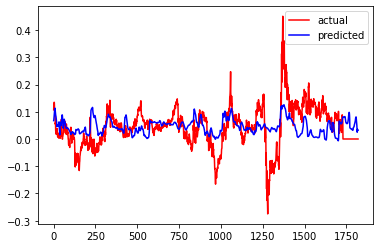

In [ ]:
plt.plot(fully_final['SPX_future_growth_90d'],label='actual',color='red')
plt.plot(fully_final['prediction'],label='predicted',color='blue')
plt.legend()


In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(fully_final['SPX_future_growth_90d'], fully_final['prediction']))
print('Mean Squared Error:', metrics.mean_squared_error(fully_final['SPX_future_growth_90d'], fully_final['prediction']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(fully_final['SPX_future_growth_90d'], fully_final['prediction'])))

Mean Absolute Error: 0.05452321040689772
Mean Squared Error: 0.005071190567927873
Root Mean Squared Error: 0.07121229225300835


In [ ]:
train_data.reset_index(inplace=True)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

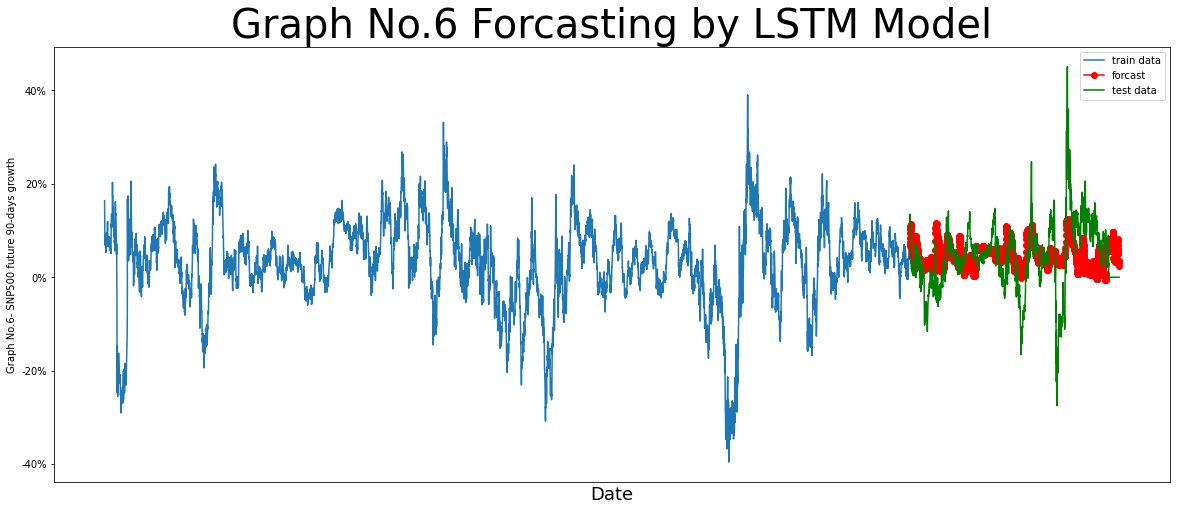

In [ ]:
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(20,8))
plt.plot(train_data['index'],train_data['SPX_future_growth_90d'],label='train data')
plt.plot(fully_final['index'],fully_final[['prediction']],label='forcast',color='red',marker = 'o')
plt.plot(fully_final['index'],fully_final[['SPX_future_growth_90d']],label='test data',color='green')



plt.title('Graph No.6 Forcasting by LSTM Model', fontsize=40,color="black")
plt.xlabel('Date',fontsize=18)
plt.ylabel('Graph No.6- SNP500 future 90-days growth',fontsize=10)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
#plt.xticks(color='white')
plt.legend()
